## **Question 1/2 | Google Doc of awnsers**
https://docs.google.com/document/d/1mSgQ0nF2l4Ey5UypvB3AxhdNQRxNrS7Ng_aVFVMFS9s/edit?tab=t.0

only relevant if the submision thing won't let me submit more than one file 

# **Question 3/4 | Clustering Banking Systems to Analyze Macroeconomic Volatility**  

This notebook explores the relationship between **banking system structures and macroeconomic volatility** by clustering countries based on key **banking sector metrics** such as efficiency, profitability, and stability.  

Once clustered, we examine how these different banking structures relate to macroeconomic fluctuations, focusing on indicators like **GDP growth, labor market stability, investment cycles, and inflation volatility.**  

The goal is to determine whether distinct banking configurations correspond to **differences in economic stability** (whilst controling for factors like economic development)




### **Strict Data Window Enforcement**
To ensure completeness in our analysis, we will only retain countries that have **data available for all years from 2000 to 2024** across all merged datasets. If a country is missing significant amounts of data for any indicator in this range, it will be **removed from the study**.

This approach ensures:
- **Consistency across variables** → No country will have missing values for any included metric.
- **A fully balanced panel dataset** → This prevents biases due to inconsistent country-year coverage.
- **Reliable cross-country comparisons** → Since all countries will have complete data, statistical inferences will be more robust.

By structuring the dataset in this way, I can conduct a rigorous analysis that meets the assignment's requirements.

In [2]:

import pandas as pd
import re

### ASSIGNMENT QUESTIONS a) b) c) d) tackled here
#first few questions importing, melting to long form, finding n countries, n years, n missing.

#why melt long? well currently its wide I want it long, then im gonna pivot
#for my purposes I want all the features on one line, tagged by year and country code to identify which row of data belongs to who and in what order

def import_melt(file_path, sheet_name=0):
    
    if file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        df.columns = df.columns.str.strip()
        
        #weird year naming
        year_cols = {col: col.split()[0] for col in df.columns if re.match(r'^\d{4} \[YR\d{4}\]$', col)}
        df.rename(columns=year_cols, inplace=True)

        df_long = df.melt(
        id_vars=['Country Name', 'Series Name', 'Country Code', "Series Code"], 
        var_name='Year',  
        value_name='Value')

 
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path, skiprows=4)
        #there was an uneeded colum in the end of all csvs downloaded from the worldbank
        df.drop(columns=[col for col in df.columns if 'Unnamed' in col], inplace=True, errors='ignore')
        #naming schems for the csv year cols were much nicer
        year_cols = [col for col in df.columns if col.isdigit()]
        df_long = df.melt(
        id_vars=['Country Name', 'Indicator Name', 'Country Code', "Indicator Code"], 
        var_name='Year',  
        value_name='Value')
    #now I can import and melt long any CSV or XLSX file from the world bank database because the formatting is all the same for all (im pretty sure) of them differing only by XLSX or CSV
    #surely this will be useful at some point down the line
  

    else:
        raise ValueError("Unsupported file format")
    
    return df_long


def get_dataset_info(df):

    #question c "count the countries"
    num_countries = df["Country Code"].nunique()
    print(f"Total number of countries: {num_countries}")

    #question c "count the years"
    num_years = df["Year"].nunique()
    start_year = df["Year"].min()
    end_year = df["Year"].max()
    print(f"Shape: {df.shape}") #just to check if the melt worked
    print(f"Total number of years: {num_years}")
    print(f"Start Year: {start_year}")
    print(f"End Year: {end_year}")

    #question d "count the missing data points"
    #inspecting the csv nans are sometimes marked as .. hence me including the .. bit
    missing_values = df.isna().sum().sum() + (df == '..').sum().sum()
    print(f"Total missing data points: {missing_values}")


#importing and melting long
bank_metrics = import_melt("data/P_Data_Extract_From_Global_Financial_Development (1).xlsx")
csvs = ["data/API_NE.GDI.TOTL.ZS_DS2_en_csv_v2_3422.csv", "data/API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_76269.csv", "data/API_SL.TLF.ACTI.ZS_DS2_en_csv_v2_77068.csv"]
gross_investment, gdp_growth, labor_force = [import_melt(csv) for csv in csvs]


# pivoting into more usable data so instead of it being like a whole coloumn that holds the indicator name and then an associated value row, now its just the indicator as a column
bank_metrics = bank_metrics.drop_duplicates()
bank_metrics = bank_metrics.pivot(
    index=['Country Name', 'Country Code', 'Year'],  #
    columns='Series Name',  
    values='Value'  
).reset_index()
bank_metrics.dropna(subset=['Country Name'], inplace=True)
bank_metrics = bank_metrics.loc[:, bank_metrics.notna().any()]  

dfs = [gross_investment, gdp_growth, labor_force]
pivoted_dfs = [
    df.drop_duplicates()
      .pivot(index=['Country Name', 'Country Code', 'Year'], columns='Indicator Name', values='Value')
      .reset_index()
      .dropna(subset=['Country Name'])
      .loc[:, lambda x: x.notna().any()]  
    for df in dfs
]
gross_investment_pivoted = pivoted_dfs[0]
gdp_growth_pivoted = pivoted_dfs[1]
labor_force_pivoted = pivoted_dfs[2]

#merging series i wanted into one df
merged_dependant = pivoted_dfs[0]  
for df in pivoted_dfs[1:]: 
    merged_dependant = merged_dependant.merge(df, on=['Country Code', 'Year', 'Country Name'], how='outer')




#final merge
og_df = bank_metrics.merge(merged_dependant, on=['Country Code', 'Country Name', 'Year'], how = "inner")





# i came from the future and added this later
# I did this to add more control variables to the data for later analysis such as gdp per capita, and a few other things
# also I thought maybe studying inflation volatility could be interesting too
# i also found out that you can select and make your own datasets with whatever indicators you want 
# which made my previou looping through and merging individual seriess extremely redundant, but it's more effort now to go back and do that so its staying there

controls = import_melt("data/P_Data_Extract_From_World_Development_Indicators.xlsx")
controls = controls.drop_duplicates()
controls = controls.pivot(
    index=['Country Name', 'Country Code', 'Year'],  #
    columns='Series Name',  
    values='Value'  
).reset_index()
controls.dropna(subset=['Country Name'], inplace=True)
controls = controls.loc[:, controls.notna().any()]  
og_df = og_df.merge(controls, on=['Country Code', 'Country Name', 'Year'], how = "inner")
og_df.to_csv("merged_data.csv", index=False)

get_dataset_info(df)
og_df.head()

Total number of countries: 266
Shape: (17024, 4)
Total number of years: 64
Start Year: 1960
End Year: 2023
Total missing data points: 9038


Country Name Country Code  Year 5-bank asset concentration  \
0  Afghanistan          AFG  2002                         ..   
1  Afghanistan          AFG  2003                         ..   
2  Afghanistan          AFG  2004                         ..   
3  Afghanistan          AFG  2005                         ..   
4  Afghanistan          AFG  2006                         ..   

  ATMs per 100,000 adults  \
0                      ..   
1                      ..   
2                0.015601   
3                0.059808   
4                0.116381   

  Account at a formal financial institution (% age 15+)  \
0                                                 ..      
1                                                 ..      
2                                                 ..      
3                                                 ..      
4                                                 ..      

  Account used for business purposes (% age 15+)  \
0                                             ..   
1                                             ..   
2                                             ..   
3                                             ..   
4                                             ..   

  Account used to receive government payments (% age 15+)  \
0                                                 ..        
1                                                 ..        
2                                                 ..        
3                                                 ..        
4                                                 ..        

  Account used to receive remittances (% age 15+)  \
0                                              ..   
1                                              ..   
2                                              ..   
3                                              ..   
4                                              ..   

  Account used to receive wages (% age 15+)  ...  \
0                                        ..  ...   
1                                        ..  ...   
2                                        ..  ...   
3                                        ..  ...   
4                                        ..  ...   

  Value of collateral needed for a loan (% of the loan amount)  \
0                                                 ..             
1                                                 ..             
2                                                 ..             
3                                                 ..             
4                                                 ..             

  Value traded excluding top 10 traded companies to total value traded (%)  \
0                                                 ..                         
1                                                 ..                         
2                                                 ..                         
3                                                 ..                         
4                                                 ..                         

  Working capital financed by banks (%) Gross capital formation (% of GDP)  \
0                                    ..                                NaN   
1                                    ..                                NaN   
2                                    ..                                NaN   
3                                    ..                                NaN   
4                                    ..                                NaN   

  GDP growth (annual %)  \
0             28.600001   
1              8.832278   
2              1.414118   
3             11.229715   
4              5.357403   

  Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)  \
0                                             47.534                                                
1                                             47.525                       

### **Note on Different N Countries**

The number of unique countries differs between the datasets (bank_metrics vs. dependent variables) due to variations in country naming conventions and included entities. While both datasets contain the same major countries, discrepancies arise because:

- Some datasets include **aggregate regions** (e.g., "Euro Area," "Sub-Saharan Africa").
- Some datasets contain **dependent territories** (e.g., "Hong Kong," "Puerto Rico").
- Country names may differ slightly (e.g., "United States" vs. "United States of America").
- A **few minor country code mismatches exist but do not affect key analysis**.

Since all **major countries** have consistent names and codes, these differences do not impact the validity of the dataset when merged.
Using Country Codes is more consistent than country names

# **Cleaning and Reducing the Dataset** 


In [81]:
#looking at our features 
#lots won't be particularly relevant to my analysis and because of the large number of features 
#I will need to be selective to features  relevant to banking efficiency and stability
for col in og_df.columns:
    print(col)

Country Name
Country Code
Year
5-bank asset concentration
ATMs per 100,000 adults
Account at a formal financial institution (% age 15+)
Account used for business purposes (% age 15+)
Account used to receive government payments (% age 15+)
Account used to receive remittances (% age 15+)
Account used to receive wages (% age 15+)
Bank Z-score
Bank accounts per 1,000 adults
Bank branches per 100,000 adults
Bank capital to total assets (%)
Bank concentration (%)
Bank cost to income ratio (%)
Bank credit to bank deposits (%)
Bank deposits to GDP (%)
Bank lending-deposit spread
Bank net interest margin (%)
Bank non-performing loans to gross loans (%)
Bank noninterest income to total income (%)
Bank overhead costs to total assets (%)
Bank regulatory capital to risk-weighted assets (%)
Bank return on assets (%, after tax)
Bank return on assets (%, before tax)
Bank return on equity (%, after tax)
Bank return on equity (%, before tax)
Banking crisis dummy (1=banking crisis, 0=none)
Central bank a

In [3]:
## There's a lot of data, so I'm reducing it to relevant indicators
feature_categories = {
    "Banking Efficiency & Stability": [
        "Bank Z-score",  # Banking system stability
        "Bank accounts per 1,000 adults",  # Access to banking services
        "Bank branches per 100,000 adults",  # Banking penetration
        "Bank capital to total assets (%)",  # Capital adequacy
        "Bank concentration (%)",  # Market share concentration
        "Bank cost to income ratio (%)",  # Operational efficiency
        "Bank credit to bank deposits (%)",  # Liquidity risk
        "Bank deposits to GDP (%)",  # Banking sector depth
        "Bank lending-deposit spread",  # Interest rate differential
        "Bank net interest margin (%)",  # Profitability of bank lending
        "Bank non-performing loans to gross loans (%)",  # Asset quality & risk
        "Bank noninterest income to total income (%)",  # Revenue diversification
        "Bank overhead costs to total assets (%)",  # Operational efficiency
        "Bank regulatory capital to risk-weighted assets (%)",  # Capital adequacy & stability
        "Bank return on assets (%, after tax)",  # Profitability measure
        "Bank return on assets (%, before tax)",  # Profitability measure
        "Bank return on equity (%, after tax)",  # Profitability for shareholders
        "Bank return on equity (%, before tax)",  # Profitability for shareholders
        "Banking crisis dummy (1=banking crisis, 0=none)",  # Indicates past crises
        "Foreign bank assets among total bank assets (%)",  # Foreign exposure in banking
        "Government bank assets among total bank assets (%)",  # Government participation in banking
        "Loans requiring collateral (%)",  # Risk management & lending security
        "Provisions to nonperforming loans (%)",  # Risk mitigation for bad loans
    ],

    "Economic Recovery Indicators": [
        "GDP growth (annual %)", #proxy for goods market health
        "Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)", #proxy for labor market health
        "Gross capital formation (% of GDP)", #investment/financial market recovery
        "Inflation, GDP deflator (annual %)" #im attempting to use this to control for development
    ],

    "Controlling for Development" : [
       "GDP per capita, PPP (current international $)" #this is my way of bucketing countries into similarish groups, you'll see why this is needed later
    ]
}

selected_columns = ["Country Name", "Country Code", "Year"]  
selected_columns += sum(feature_categories.values(), [])  
df_filtered = og_df[selected_columns]

df_filtered.head()



Country Name Country Code  Year Bank Z-score Bank accounts per 1,000 adults  \
0  Afghanistan          AFG  2002           ..                             ..   
1  Afghanistan          AFG  2003           ..                             ..   
2  Afghanistan          AFG  2004           ..                             ..   
3  Afghanistan          AFG  2005           ..                             ..   
4  Afghanistan          AFG  2006     48.99729                             ..   

  Bank branches per 100,000 adults Bank capital to total assets (%)  \
0                               ..                               ..   
1                               ..                               ..   
2                         0.366621                               ..   
3                         0.583124                               ..   
4                         0.923777                               ..   

  Bank concentration (%) Bank cost to income ratio (%)  \
0                     ..                            ..   
1                     ..                            ..   
2                     ..                            ..   
3                     ..                            ..   
4               97.32105                      61.60965   

  Bank credit to bank deposits (%)  ...  \
0                               ..  ...   
1                               ..  ...   
2                               ..  ...   
3                               ..  ...   
4                         52.90562  ...   

  Banking crisis dummy (1=banking crisis, 0=none)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

  Foreign bank assets among total bank assets (%)  \
0                                              ..   
1                                              ..   
2                                              ..   
3                                              ..   
4                                              ..   

  Government bank assets among total bank assets (%)  \
0                                                 ..   
1                                                 ..   
2                                                 ..   
3                                                 ..   
4                                                 ..   

  Loans requiring collateral (%) Provisions to nonperforming loans (%)  \
0                             ..                                    ..   
1                             ..                                    ..   
2                             ..                                    ..   
3                             ..                                    ..   
4                             ..                                    ..   

  GDP growth (annual %)  \
0             28.600001   
1              8.832278   
2              1.414118   
3             11.229715   
4              5.357403   

  Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)  \
0                                             47.534                                                
1                                             47.525                                                
2                                             47.534                                                
3                                             47.562                                                
4                                             47.605                                                

  Gross capital formation (% of GDP) Inflation, GDP deflator (annual %)  \
0                                NaN                           6.125522   
1                                NaN                          11.655238   
2                                NaN                          11.

# Reducing the Dataset by data avaliability


I plan to reduce the dataset to data that is the most available and complete across a broad spectrum of countries to ensure a more comprehensive and applicable analysis. This approach avoids reliance on heavy imputation or interpolated data, maintaining the integrity of the study.

### Steps:
1. Remove features that have a high percentage of missing data across all countries.
2. Remove countries that do not have data on the most widely available metrics.
3. Arrive at a dataset filtered for availability while maintaining a balance between country and feature retention, ensuring the dataset remains large enough for meaningful analysis.

This process will produce a dataset that is well-structured and reliable, reducing gaps that could introduce inconsistencies in the analysis.



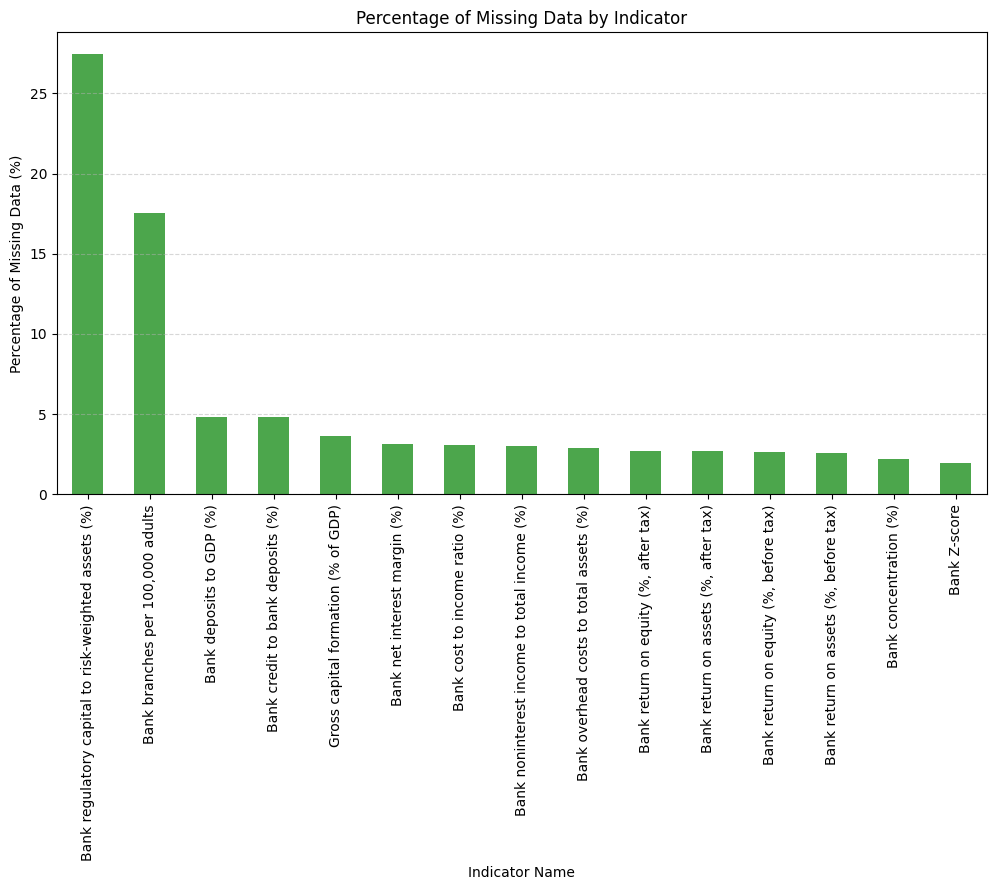

In [17]:
import matplotlib.pyplot as plt

#calc missing %s
non_id_columns = [col for col in df_filtered.columns if col not in ["Country Name", "Country Code", "Year"]]
missing_percentages = df_filtered[non_id_columns].apply(
    lambda x: ((x.astype(str) == "..") | (x == 0) | (x.isna())).sum() / len(x) * 100
)
missing_percentages = missing_percentages[missing_percentages > 0]
missing_percentages = missing_percentages.sort_values(ascending=False)

#plotting
plt.figure(figsize=(12, 6))
missing_percentages.plot(kind="bar", color="green", alpha=0.7)
plt.title("Percentage of Missing Data by Indicator")
plt.xlabel("Indicator Name")
plt.ylabel("Percentage of Missing Data (%)")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


Retained 19 features with at most 50% missing data.


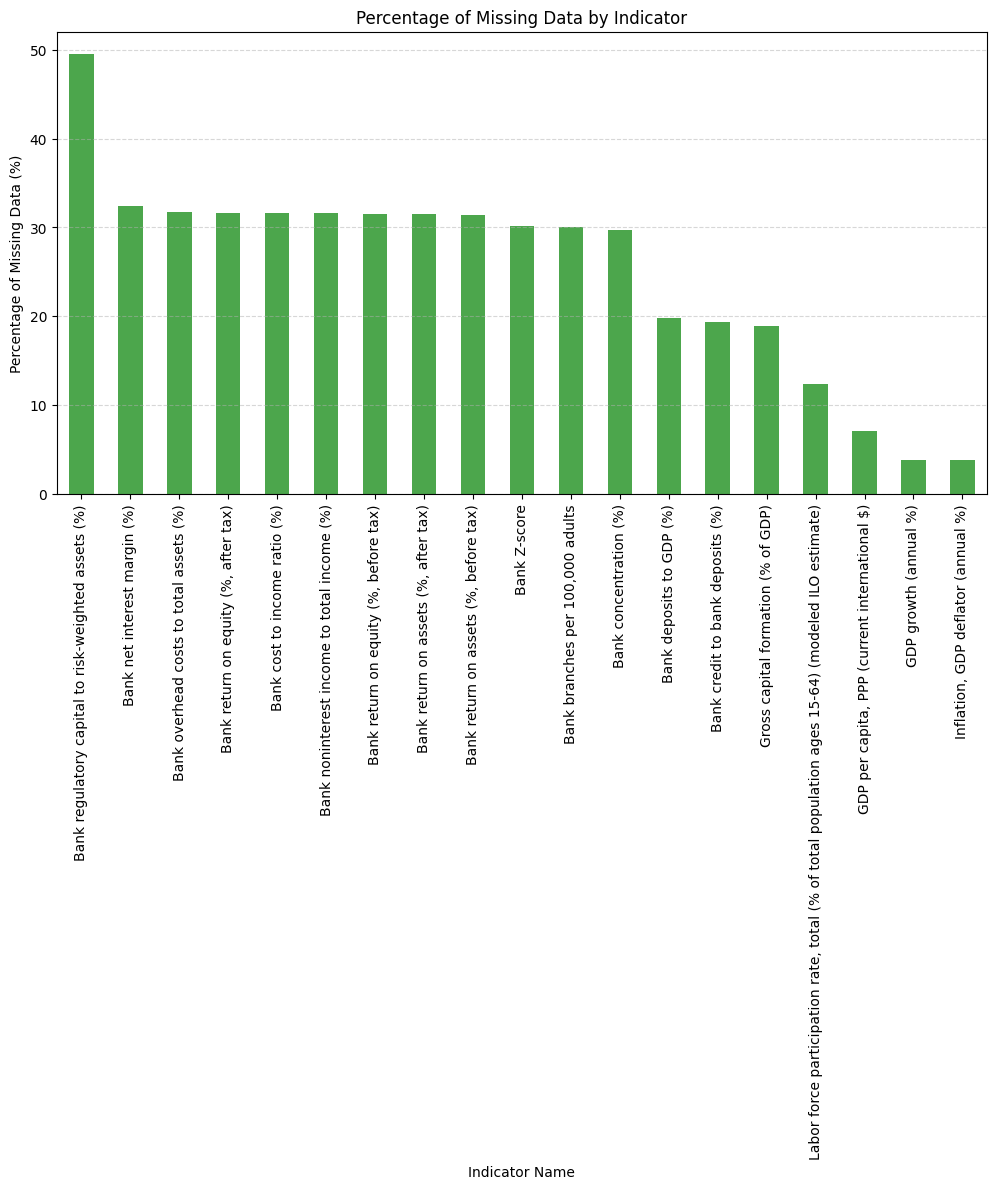

In [5]:

missing_threshold = 50  #choosing a threshold

#same code as above cell really
non_id_columns = [col for col in df_filtered.columns if col not in ["Country Name", "Country Code", "Year"]]
missing_percentages_features = df_filtered[non_id_columns].apply(
    lambda x: ((x.astype(str) == "..") | (x == 0) | (x.isna())).sum() / len(x) * 100
)

#selects valid features only
valid_features = missing_percentages_features[missing_percentages_features <= missing_threshold].index
#filtering by said features
df_filtered_valid_features = df_filtered[["Country Name", "Country Code", "Year"] + list(valid_features)].copy()
print(f"Retained {len(valid_features)} features with at most {missing_threshold}% missing data.")


#non id cols after filtering by feature missingness threshold
non_id_columns = [col for col in df_filtered_valid_features.columns if col not in ["Country Name", "Country Code", "Year"]]

missing_percentages = df_filtered_valid_features[non_id_columns].apply(
    lambda x: ((x.astype(str) == "..") | (x == 0) | (x.isna())).sum() / len(x) * 100
)
#not plotting stuff with nothing missing
missing_percentages = missing_percentages[missing_percentages > 0]
missing_percentages = missing_percentages.sort_values(ascending=False)

#plotting
plt.figure(figsize=(12, 6))
missing_percentages.plot(kind="bar", color="green", alpha=0.7)
plt.title("Percentage of Missing Data by Indicator")
plt.xlabel("Indicator Name")
plt.ylabel("Percentage of Missing Data (%)")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()



# Does it change when we eliminate countries with very poor data avaliability?
when we filter out countries with a high amount of missing data, will our % missingness in the dataset signficiantly improve?

Retained 125 countries with ≥85% data.


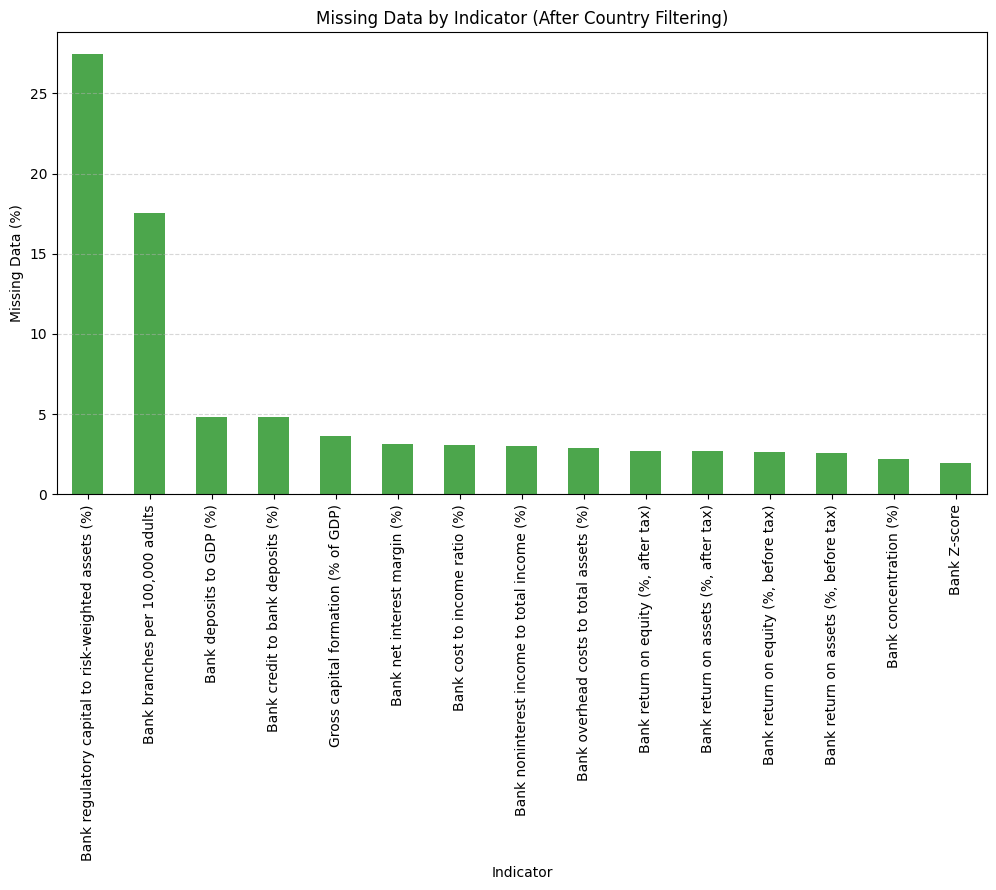

In [6]:
import matplotlib.pyplot as plt

#this filters out countries with no data, that would be heavily imputed which would in turn skew any kind of meaningful analysi of variability in macroeconomic factors
#I played around with the threshold for a while trying to find a good balance and mix of coutnries across a broad range of factors like region, development, etc without sacrificng too much data avalibility
MIN_DATA_THRESHOLD = 85  


non_id_cols = [col for col in df_filtered_valid_features.columns if col not in {"Country Name", "Country Code", "Year"}]

#calc missing %s
missing_pct_country = (
    df_filtered_valid_features.groupby("Country Name")[non_id_cols]
    .apply(lambda x: (((x.astype(str) == "..") | (x == 0) | x.isna()).sum().sum()) / x.size * 100)
)

#filtering based on whether or not the country survives the threshold
valid_countries = missing_pct_country[missing_pct_country < (100 - MIN_DATA_THRESHOLD)].index
df_filtered = df_filtered_valid_features[df_filtered_valid_features["Country Name"].isin(valid_countries)].copy()
#how many lived
print(f"Retained {df_filtered['Country Name'].nunique()} countries with ≥{MIN_DATA_THRESHOLD}% data.")

missing_pct = (
    df_filtered[non_id_cols]
    .apply(lambda x: (((x.astype(str) == "..") | (x == 0) | x.isna()).sum()) / len(x) * 100)
    .loc[lambda x: x > 0]
    .sort_values(ascending=False)
)

plt.figure(figsize=(12, 6))
missing_pct.plot(kind="bar", color="green", alpha=0.7)
plt.title("Missing Data by Indicator (After Country Filtering)")
plt.xlabel("Indicator")
plt.ylabel("Missing Data (%)")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


## Nature of Missingness in the Dataset  

Countries with significant missing data share common traits:  
- Lower GDP per capita – weaker financial institutions and lower banking penetration.  
- Political instability – wars, regime changes disrupt data reporting.  
- Underdeveloped banking systems – fewer recorded transactions and indicators.  
- Limited data collection – insufficient resources or incentives for systematic reporting.  

---

## Impact on Analysis  

### 1. Skewed Representation  
Data is more complete for wealthier, stable economies, which may bias conclusions.  
Missing data is not missing at random, often reflecting deeper structural issues in financial risk.  

### 2. Limited Comparability  
Well-documented financial systems dominate the dataset.  
Direct comparisons between developed and developing economies may be misleading.  

### 3. Survivorship Bias  
Stable economies may appear more resilient than they actually are.  
Financially unstable countries with missing data may be underrepresented.  

### 4. Practical Considerations  
Insights from data-rich nations may not apply to missing-data regions.  
This could reinforce financial exclusion in underrepresented economies.  

---

## Mitigation Strategy  

To reduce bias, countries are grouped by GDP per capita before clustering. This ensures comparisons occur within economically similar groups, balancing representation and improving comparability.  

### Why GDP per Capita as a Control?  
It prevents economic differences from being mistaken for policy-driven banking efficiency.  
It reduces misleading correlations caused by structural disparities.  
It accounts for informal lending and banking access gaps in emerging economies.  


In [8]:
#im eliminating features with more than 5% missing values because I dont want to rely heavily on imputatiton 
missing_threshold = 5  
valid_features = df_filtered.drop(columns=["Country Name", "Country Code", "Year"]).apply(
    lambda x: ((x.astype(str) == "..") | (x == 0) | (x.isna())).mean() * 100
).loc[lambda x: x <= missing_threshold].index
df_filtered_valid_valid = df_filtered[["Country Name", "Country Code", "Year"] + list(valid_features)]
df_filtered_valid_valid.to_csv("merged_data_reduced.csv", index=False)
#countries in the filtered df
valid_countries_list = df_filtered_valid_valid["Country Name"].unique()
print(valid_countries_list)

print("\n Info:")
get_dataset_info(df_filtered_valid_valid)
df_filtered_valid_valid.columns


### theres a nice mix of countries here if you look through the list
### different regions, economic systems, development stage, impoters/exporters, and so on



['Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas, The' 'Bahrain' 'Bangladesh' 'Belarus' 'Belgium'
 'Benin' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Chile' 'China'
 'Congo, Dem. Rep.' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cyprus'
 'Denmark' 'Dominican Republic' 'Ecuador' 'Egypt, Arab Rep.' 'El Salvador'
 'Estonia' 'Eswatini' 'Finland' 'France' 'Georgia' 'Germany' 'Ghana'
 'Greece' 'Guatemala' 'Guyana' 'Haiti' 'Honduras' 'Hong Kong SAR, China'
 'Hungary' 'India' 'Indonesia' 'Ireland' 'Israel' 'Italy' 'Jamaica'
 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Kuwait' 'Kyrgyz Republic' 'Latvia'
 'Lebanon' 'Lesotho' 'Libya' 'Lithuania' 'Luxembourg' 'Macao SAR, China'
 'Madagascar' 'Malawi' 'Malaysia' 'Mali' 'Malta' 'Mauritania' 'Mauritius'
 'Mexico' 'Moldova' 'Mongolia' 'Montenegro' 'Morocco' 'Mozambique'
 'Namibia' 'Nepal' 'Netherlands' 'Nicaragua' 'Niger' 'Nigeria'
 

Index(['Country Name', 'Country Code', 'Year', 'Bank Z-score',
       'Bank concentration (%)', 'Bank cost to income ratio (%)',
       'Bank credit to bank deposits (%)', 'Bank deposits to GDP (%)',
       'Bank net interest margin (%)',
       'Bank noninterest income to total income (%)',
       'Bank overhead costs to total assets (%)',
       'Bank return on assets (%, after tax)',
       'Bank return on assets (%, before tax)',
       'Bank return on equity (%, after tax)',
       'Bank return on equity (%, before tax)', 'GDP growth (annual %)',
       'Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)',
       'Gross capital formation (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'GDP per capita, PPP (current international $)'],
      dtype='object')

## Imputing Remaining Missing Data

### Next Steps
The previous step filtered the dataset by availability, effectively dropping NaNs that would require excessive imputation. However, some missing values remain, and this section will address them.  

The features requiring imputation are listed below (excluding the two furthest left, which were removed for exceeding the 5% threshold). Since these features capture trends over time within each country, imputation must preserve both the **temporal structure** and **country-specific patterns** in the data.  

---

### Imputation Strategy
1. Country-Level Imputation → Missing values are filled within each country’s historical data to maintain consistency.  
2. Time-Series Awareness → Methods ensure that trends and seasonality are preserved.  
3. No Future Leakage → Only past values are used to prevent data contamination in any potential predictive modeling.  

---

### Primary Approach  
- Linear Interpolation per Country → Missing values are filled using time-based linear interpolation to maintain continuity and avoid bias.  
- LOCF (Last Observation Carried Forward) for Initial Gaps → If missing values appear at the start of a time series, the firs/last available value is carried back/forward to ensure a consistent baseline.  




In [9]:
#sorting by time and year so its all in the right place
df_filtered_valid_valid = df_filtered_valid_valid.sort_values(by=['Country Name', 'Year'])

#features to impute up
features = [
    'Bank Z-score', 'Bank concentration (%)', 'Bank cost to income ratio (%)',
    'Bank credit to bank deposits (%)', 'Bank deposits to GDP (%)',
    'Bank net interest margin (%)', 'Bank noninterest income to total income (%)',
    'Bank overhead costs to total assets (%)', 'Bank return on assets (%, after tax)',
    'Bank return on assets (%, before tax)', 'Bank return on equity (%, after tax)',
    'Bank return on equity (%, before tax)', 'GDP growth (annual %)',
    'Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)', 'Gross capital formation (% of GDP)', "GDP per capita, PPP (current international $)", "Inflation, GDP deflator (annual %)"
]

#sort dataframe  
df_filtered_valid_valid=df_filtered_valid_valid.sort_values(["Country Name","Year"])

#convert to numeric  
df_filtered_valid_valid[features]=df_filtered_valid_valid[features].apply(pd.to_numeric,errors="coerce")

#drop countries missing any feature entirely  
df_filtered_valid_valid=df_filtered_valid_valid.groupby("Country Name").filter(lambda x:x[features].notna().sum().min()>0)

#impute per country  
for country in df_filtered_valid_valid["Country Name"].unique():  
    mask=df_filtered_valid_valid["Country Name"]==country  
    country_data=df_filtered_valid_valid.loc[mask,features].copy()  
    
    country_data.iloc[0]=country_data.iloc[0].ffill()  
    country_data.iloc[-1]=country_data.iloc[-1].bfill()  
    country_data=country_data.interpolate(method="linear",limit_direction="both")  
    
    df_filtered_valid_valid.loc[mask,features]=country_data  

#lost malawi due to completely missing gross national investment  </3
get_dataset_info(df_filtered_valid_valid)  
df_filtered_valid_valid.head()


Total number of countries: 121
Shape: (2420, 20)
Total number of years: 20
Start Year: 2002
End Year: 2021
Total missing data points: 0


Country Name Country Code  Year  Bank Z-score  Bank concentration (%)  \
20      Albania          ALB  2002      18.19811                94.63335   
21      Albania          ALB  2003      15.49718                95.53010   
22      Albania          ALB  2004      13.55628                95.60901   
23      Albania          ALB  2005      15.71617                94.10137   
24      Albania          ALB  2006      14.01966                91.02962   

    Bank cost to income ratio (%)  Bank credit to bank deposits (%)  \
20                       64.71389                          14.25826   
21                       50.96541                          16.30019   
22                       58.65704                          19.45933   
23                       54.77617                          29.11831   
24                       58.62713                          38.70012   

    Bank deposits to GDP (%)  Bank net interest margin (%)  \
20                  45.41947                      3.282845   
21                  46.96875                      3.675041   
22                  49.49909                      3.935590   
23                  52.80478                      4.368758   
24                  57.65782                      4.683154   

    Bank noninterest income to total income (%)  \
20                                     25.75918   
21                                     21.96019   
22                                     19.57280   
23                                     15.28876   
24                                     13.47777   

    Bank overhead costs to total assets (%)  \
20                                 2.583322   
21                                 2.220849   
22                                 2.529881   
23                                 2.410366   
24                                 2.691264   

    Bank return on assets (%, after tax)  \
20                              0.678887   
21                              1.156812   
22                              0.797742   
23                              1.615281   
24                              1.286695   

    Bank return on assets (%, before tax)  \
20                               0.977099   
21                               1.478971   
22                               1.178828   
23                               2.065830   
24                               1.644573   

    Bank return on equity (%, after tax)  \
20                              7.317695   
21                             13.630380   
22                             11.059260   
23                             22.691390   
24                             18.573870   

    Bank return on equity (%, before tax)  GDP growth (annual %)  \
20                               10.53210               4.536524   
21                               17.42628               5.528637   
22                               16.34234               5.514668   
23                               29.02068               5.526424   
24                               23.73997               5.902659   

    Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)  \
20                                             66.172                                                 
21                                             65.239                                                 
22                                             64.299                                                 
23                                             63.360                                                 
24                                             62.426                                                 

    Gross capital formation (% of GDP)  Inflation, GDP deflator (annual %)  \
20                           35.264062                            3.647476   
21                           33.896863                            5.198635   
22                           34.196746                            3.152369   
23             

In [10]:
###trying to control for development before clustering dont want banking cluster to just be a proxy for developed/developing  
import pandas as pd  

df=df_filtered_valid_valid  

#calc 20yr avg gdp per capita  
df["Avg_GDP_per_capita"]=df.groupby("Country Name")["GDP per capita, PPP (current international $)"].transform("mean")  

#assign income groups based on percentiles and group
df["Income_Group"]=pd.qcut(df["Avg_GDP_per_capita"],q=3,labels=[1,2,3]).astype(int)  
income_grouped=df.groupby("Income_Group")["Country Name"].unique().to_dict()  

#print groups  
for group,countries in income_grouped.items():  
    print(f"\n### Income Group {group} Countries:\n")  
    print(", ".join(countries))  

#to see if the column was actually made
df.head()


### Income Group 1 Countries:

Angola, Bangladesh, Benin, Bolivia, Burkina Faso, Burundi, Cambodia, Cameroon, Congo, Dem. Rep., Cote d'Ivoire, El Salvador, Ghana, Guatemala, Haiti, Honduras, India, Indonesia, Jamaica, Jordan, Kenya, Kyrgyz Republic, Lesotho, Madagascar, Mali, Mauritania, Moldova, Morocco, Mozambique, Namibia, Nepal, Nicaragua, Niger, Pakistan, Philippines, Rwanda, Senegal, Sierra Leone, Tanzania, Uganda, Uzbekistan, Zambia

### Income Group 2 Countries:

Albania, Algeria, Argentina, Armenia, Azerbaijan, Belarus, Bosnia and Herzegovina, Botswana, Brazil, Bulgaria, Chile, China, Costa Rica, Croatia, Dominican Republic, Ecuador, Egypt, Arab Rep., Georgia, Guyana, Kazakhstan, Latvia, Lebanon, Libya, Malaysia, Mauritius, Mexico, Mongolia, Montenegro, North Macedonia, Panama, Paraguay, Peru, Romania, Russian Federation, Serbia, South Africa, Thailand, Tunisia, Ukraine, Uruguay

### Income Group 3 Countries:

Australia, Austria, Bahamas, The, Bahrain, Belgium, Canada, Cyprus

Country Name Country Code  Year  Bank Z-score  Bank concentration (%)  \
20      Albania          ALB  2002      18.19811                94.63335   
21      Albania          ALB  2003      15.49718                95.53010   
22      Albania          ALB  2004      13.55628                95.60901   
23      Albania          ALB  2005      15.71617                94.10137   
24      Albania          ALB  2006      14.01966                91.02962   

    Bank cost to income ratio (%)  Bank credit to bank deposits (%)  \
20                       64.71389                          14.25826   
21                       50.96541                          16.30019   
22                       58.65704                          19.45933   
23                       54.77617                          29.11831   
24                       58.62713                          38.70012   

    Bank deposits to GDP (%)  Bank net interest margin (%)  \
20                  45.41947                      3.282845   
21                  46.96875                      3.675041   
22                  49.49909                      3.935590   
23                  52.80478                      4.368758   
24                  57.65782                      4.683154   

    Bank noninterest income to total income (%)  ...  \
20                                     25.75918  ...   
21                                     21.96019  ...   
22                                     19.57280  ...   
23                                     15.28876  ...   
24                                     13.47777  ...   

    Bank return on assets (%, before tax)  \
20                               0.977099   
21                               1.478971   
22                               1.178828   
23                               2.065830   
24                               1.644573   

    Bank return on equity (%, after tax)  \
20                              7.317695   
21                             13.630380   
22                             11.059260   
23                             22.691390   
24                             18.573870   

    Bank return on equity (%, before tax)  GDP growth (annual %)  \
20                               10.53210               4.536524   
21                               17.42628               5.528637   
22                               16.34234               5.514668   
23                               29.02068               5.526424   
24                               23.73997               5.902659   

    Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)  \
20                                             66.172                                                 
21                                             65.239                                                 
22                                             64.299                                                 
23                                             63.360                                                 
24                                             62.426                                                 

    Gross capital formation (% of GDP)  Inflation, GDP deflator (annual %)  \
20                           35.264062                            3.647476   
21                           33.896863                            5.198635   
22                           34.196746                            3.152369   
23                           36.869676                            3.306818   
24                           35.697519                            2.478189   

    GDP per capita, PPP (current international $)  Avg_GDP_per_capita  \
20                                    4661.392818         9983.252198   
21                                    5000.343295         9983.252198   
22                                    5427.874773         9983.252198   
23                                    5865.305637         9983.252198   
24         

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df=df_filtered_valid_valid 

##drop Greece from the dataset
df = df[df["Country Name"] != "Greece"]
#greece is removed due to extreme banking instability, which distorts clustering in high-income countries.
#greece was so different from every other nation with comparable GDP it managed to be alone in its own cluster
#its banks financial metrics were so poor over the past 20 years that they rivaled nations like the DRC 
#a nation that is arguably the most poltiically instable place on earth (just an interesting obersation into the absolute situation of Greek financial instituions)


#key banking metrics for clustering  
banking_metrics=[
    'Bank Z-score','Bank concentration (%)','Bank cost to income ratio (%)',
    'Bank credit to bank deposits (%)','Bank deposits to GDP (%)',
    'Bank net interest margin (%)','Bank noninterest income to total income (%)',
    'Bank overhead costs to total assets (%)','Bank return on assets (%, after tax)',
    'Bank return on assets (%, before tax)','Bank return on equity (%, after tax)',
    'Bank return on equity (%, before tax)'
]

#aggregate banking metrics per country  
df_country=df.groupby(["Country Name","Income_Group"],as_index=False)[banking_metrics].mean()
df_country["Banking_Cluster"]=-1  

#perform clustering within each income group  
#scaling helps with clustering so BIG feautres don't dominate and skew clustering in the favour of any one outsized feature
for income_group in df_country["Income_Group"].unique():  
    subset=df_country[df_country["Income_Group"]==income_group].copy()  
    if len(subset)>1:  
        scaler=StandardScaler()  
        banking_scaled=scaler.fit_transform(subset[banking_metrics])  
        kmeans=KMeans(n_clusters=2,random_state=420,n_init=10)  
        df_country.loc[df_country["Income_Group"]==income_group,"Banking_Cluster"]=kmeans.fit_predict(banking_scaled)  

#map cluster labels  
df_country["Banking_Cluster"]=df_country["Banking_Cluster"].map({0:"c0",1:"c1"})  

#merge cluster labels back  
df=df.merge(df_country[["Country Name","Banking_Cluster"]],on="Country Name",how="left")  

#examine cluster characteristics  
cluster_characteristics=df_country.groupby(["Income_Group","Banking_Cluster"])[banking_metrics].mean()  
cluster_characteristics


Bank Z-score  Bank concentration (%)  \
Income_Group Banking_Cluster                                         
1            c0                  20.023180               60.914152   
             c1                  14.833843               73.834069   
2            c0                  16.466130               71.318678   
             c1                  15.319785               58.907874   
3            c0                  18.634610               76.540464   
             c1                  15.784599               68.667960   

                              Bank cost to income ratio (%)  \
Income_Group Banking_Cluster                                  
1            c0                                   58.447159   
             c1                                   59.165383   
2            c0                                   58.093227   
             c1                                   54.785825   
3            c0                                   48.936678   
             c1                                   63.124323   

                              Bank credit to bank deposits (%)  \
Income_Group Banking_Cluster                                     
1            c0                                      84.055752   
             c1                                      67.538850   
2            c0                                      98.427316   
             c1                                     103.451605   
3            c0                                     102.050828   
             c1                                     113.524326   

                              Bank deposits to GDP (%)  \
Income_Group Banking_Cluster                             
1            c0                              40.165794   
             c1                              26.675966   
2            c0                              33.849235   
             c1                              56.020208   
3            c0                              77.765631   
             c1                             111.756035   

                              Bank net interest margin (%)  \
Income_Group Banking_Cluster                                 
1            c0                                   5.125703   
             c1                                   8.691942   
2            c0                                   7.085400   
             c1                                   4.406410   
3            c0                                   2.740951   
             c1                                   1.368352   

                              Bank noninterest income to total income (%)  \
Income_Group Banking_Cluster                                                
1            c0                                                 36.536441   
             c1                                                 36.561425   
2            c0                                                 39.211284   
             c1                                                 35.726390   
3            c0                                                 36.988188   
             c1                                                 45.035104   

                              Bank overhead costs to total assets (%)  \
Income_Group Banking_Cluster                                            
1            c0                                              4.203177   
             c1                                              6.546343   
2            c0                                              5.920997   
             c1                                              3.663821   
3            c0                                              1.827977   
             c1                                              1.438332   

                              Bank return on assets (%, after tax)  \
Income_Group Banking_Cluster                                         
1            c0                                           1.574053   
             c1                                           3.0

## **What's each cluster about?**
here i'll try and analyse correlations and cluster statistics to identify what each cluster is actually grouping by

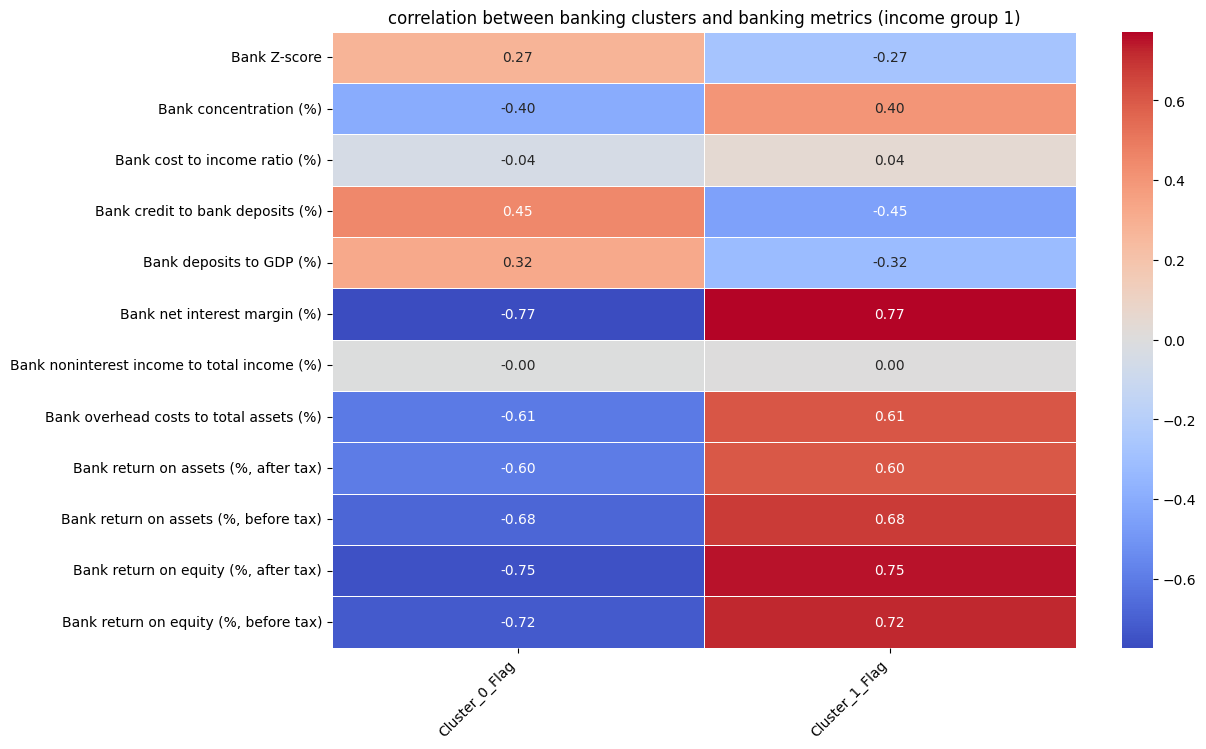

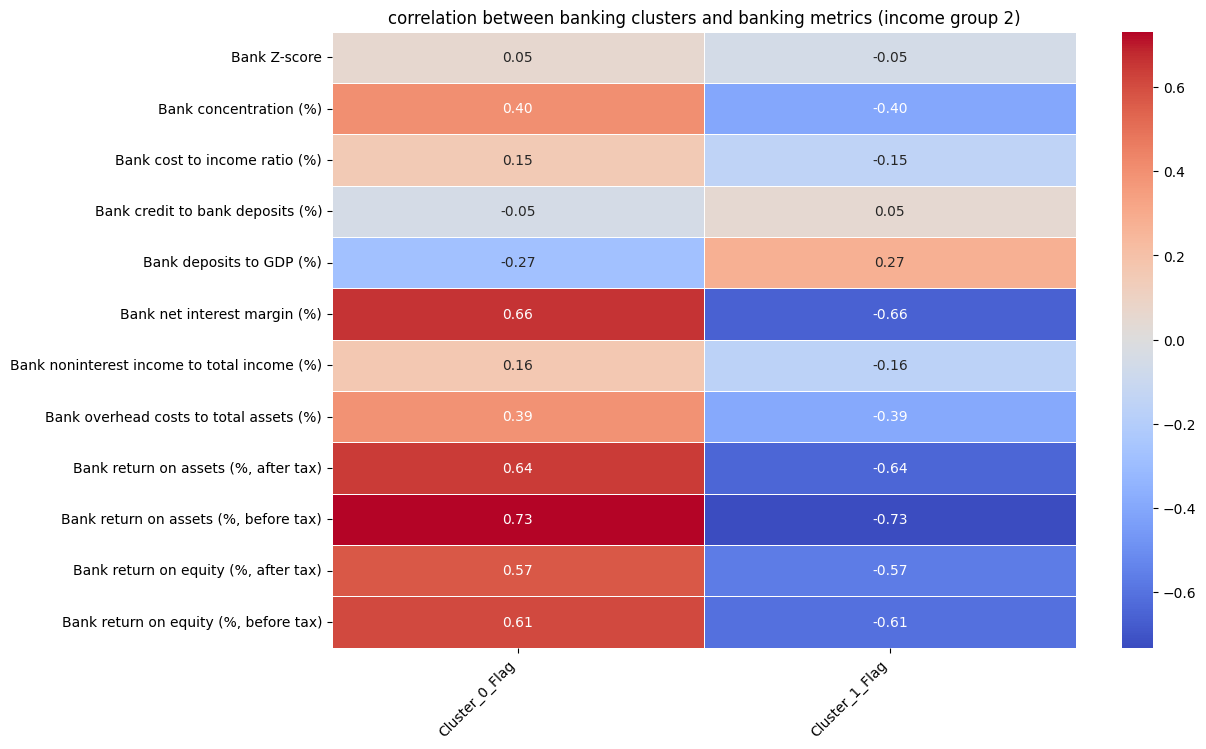

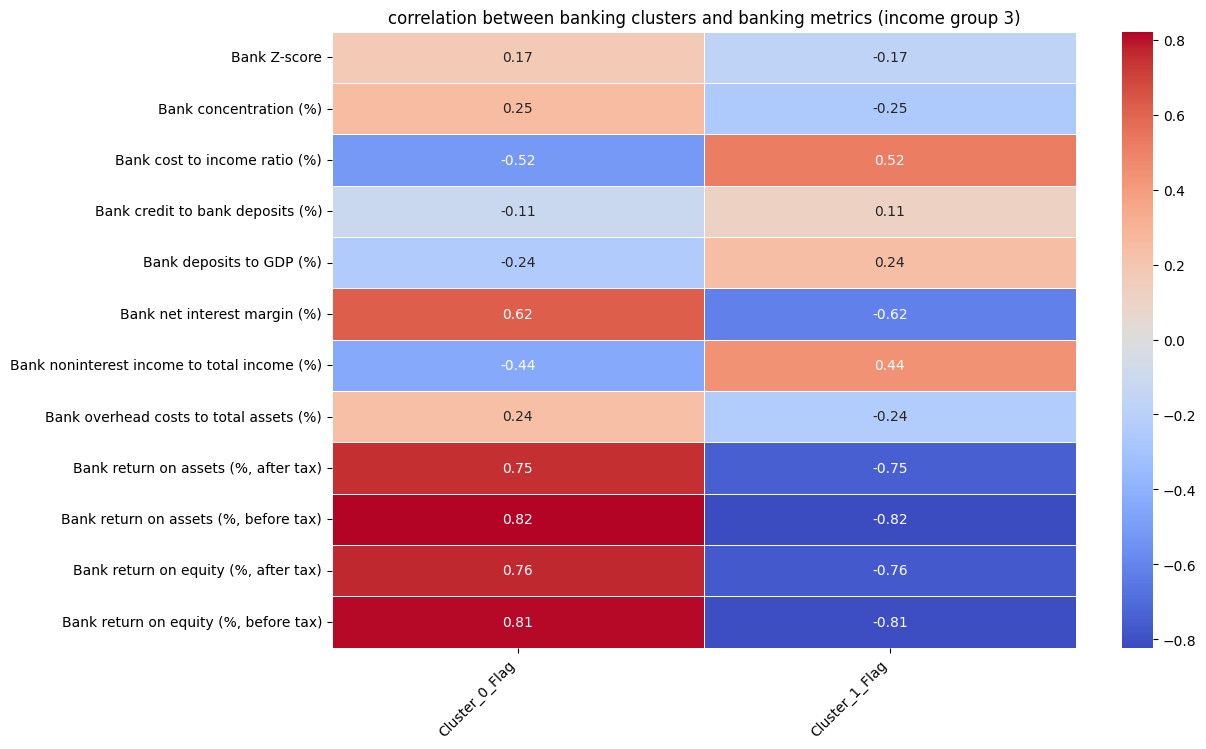

In [26]:
import seaborn as sns
#binary flags for cluster membership  
df_country["Cluster_0_Flag"]=(df_country["Banking_Cluster"]=="c0").astype(int)  
df_country["Cluster_1_Flag"]=(df_country["Banking_Cluster"]=="c1").astype(int)  

income_groups=[1,2,3]  

#correlation heatmap per income group  
for income_group in income_groups:  
    df_subset=df_country[df_country["Income_Group"]==income_group]  
    correlation_with_clusters=df_subset[banking_metrics+["Cluster_0_Flag","Cluster_1_Flag"]].corr(numeric_only=True)[["Cluster_0_Flag","Cluster_1_Flag"]].drop(["Cluster_0_Flag","Cluster_1_Flag"],errors="ignore")  
    
    plt.figure(figsize=(12,8))  
    sns.heatmap(correlation_with_clusters,annot=True,fmt=".2f",cmap="coolwarm",linewidths=0.5)  
    plt.title(f"correlation between banking clusters and banking metrics (income group {income_group})")  
    plt.xticks(rotation=45,ha="right")  


# Intra-Cluster Correlations: How Metrics Correlate Within Each Cluster

**To better understand the internal dynamics of each banking cluster, we can analyze how different metrics correlate within each group.**

**Comparing these correlations across clusters provides insights into their structural differences and banking strategies.**

**Hopefully this helps me figure out what each cluster represents**

---


*example usage*


## Speculation on Cluster 1 (Group 3)

### More Competitive Banking Environment → Lower Concentration & Greater Fragmentation
- The negative correlation (-0.57) between bank stability (Z-score) and concentration suggests that higher competition prevents monopolies from dominating.  
- More banks compete for market share, leading to a fragmented banking system rather than one dominated by a few large banks.  

### Tighter Profit Margins → Weak Link Between Net Interest Margins & Profitability
- In competitive banking markets, interest rate spreads are compressed as banks aggressively compete on loan pricing.  
- The low correlation between net interest margins and overall profitability (ROA: 0.08, ROE: -0.07) indicates that banks must diversify revenue streams beyond traditional lending.  

### More Aggressive Lending → Higher Credit-to-Deposit Ratios
- The positive correlation (0.49) between credit-to-deposit ratios and market concentration suggests that banks in fragmented, competitive environments lend more relative to deposits.  
- With narrower margins, banks compensate by increasing loan volume, making lending a primary driver of profitability.  

### Diversified Revenue Streams → Higher Reliance on Fees & Services
- The strong correlation (0.54) between cost-to-income ratio and non-interest income implies that banks in Cluster 1 supplement profits through fees, asset management, and investment services.  
- This reduces dependence on interest-based income, aligning with the competitive nature of these markets.  


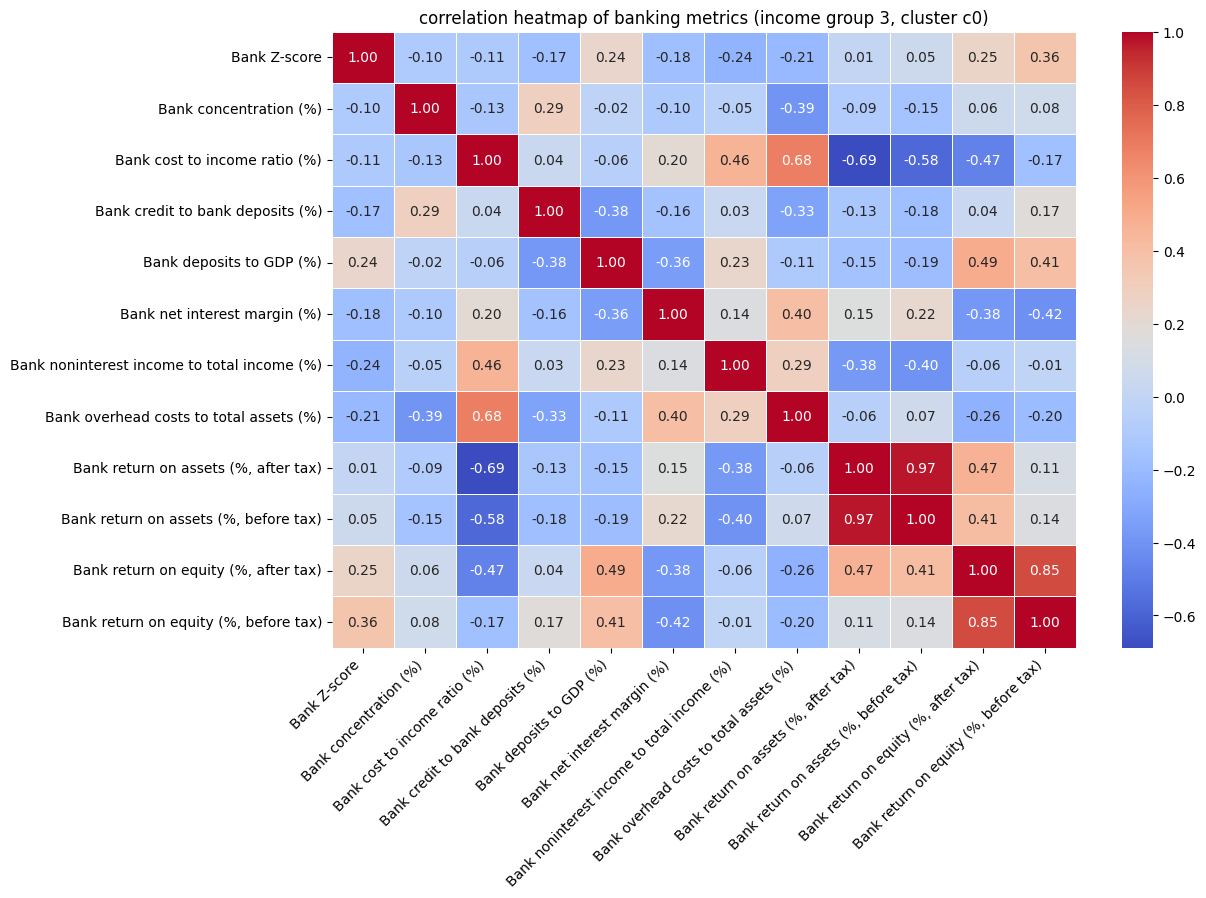

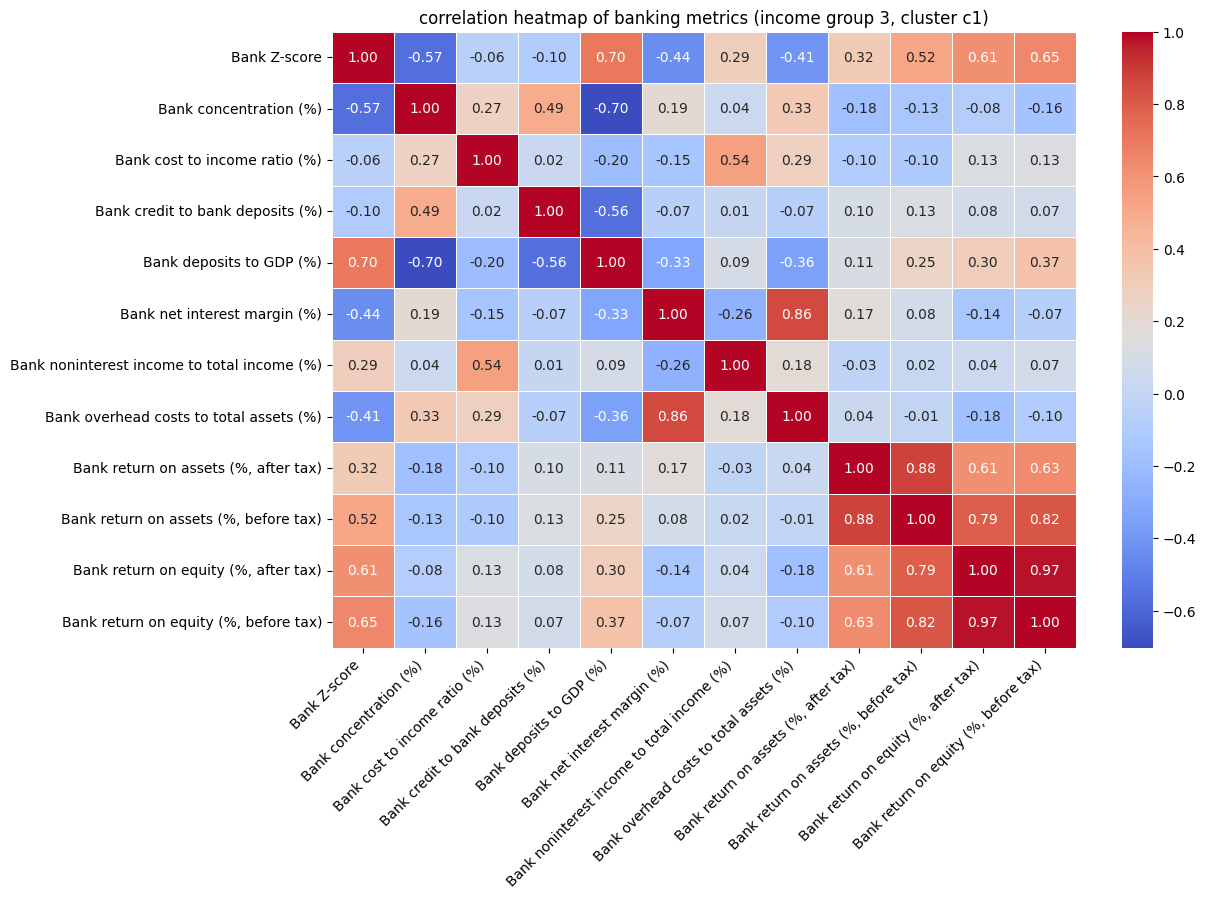

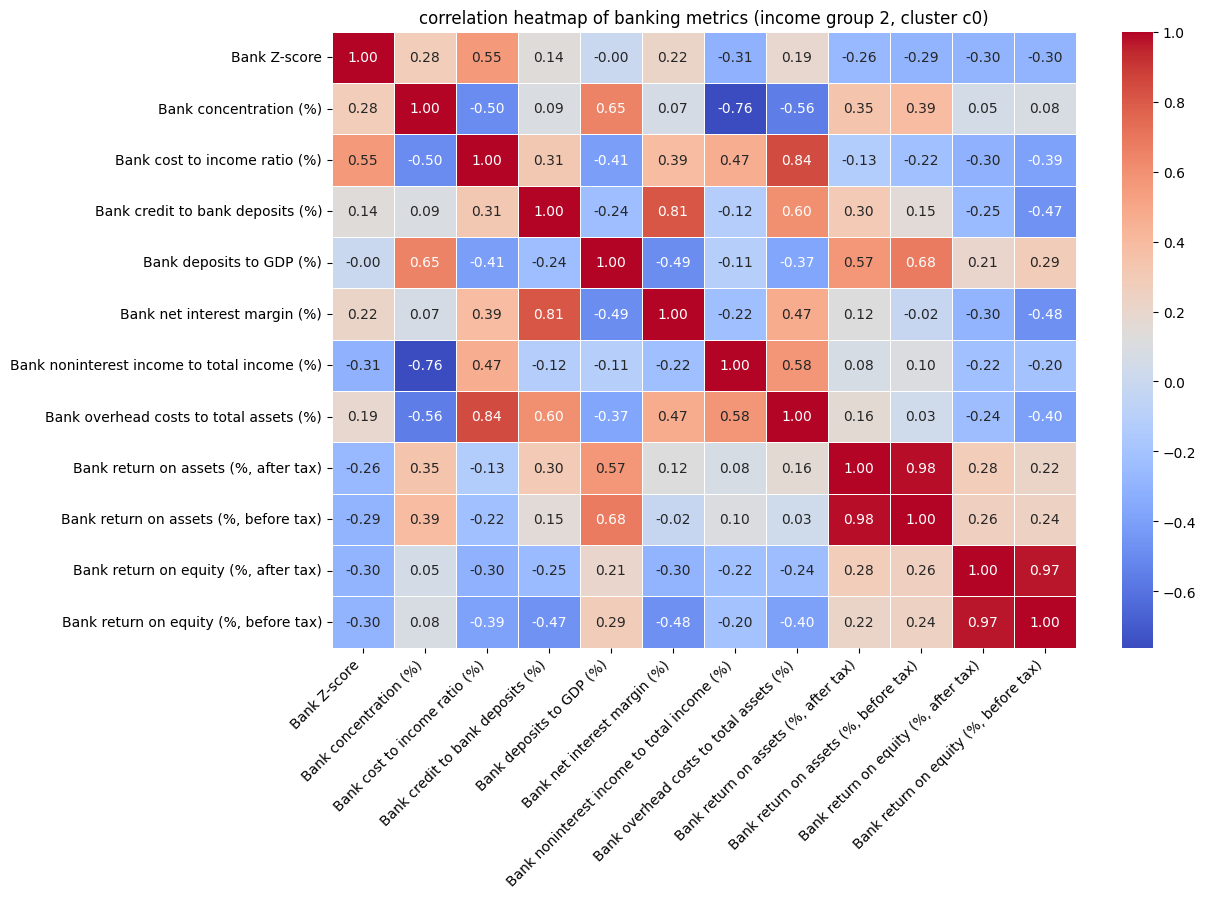

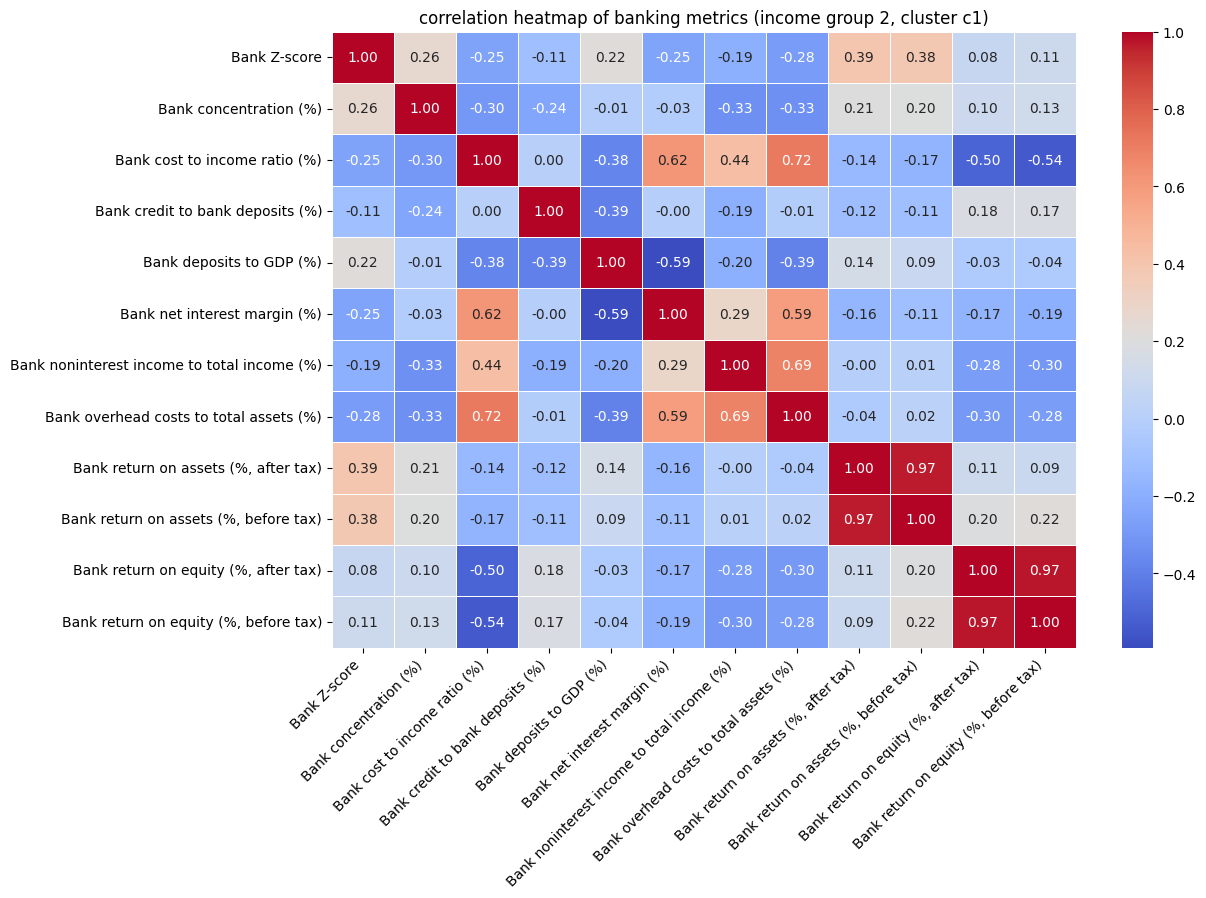

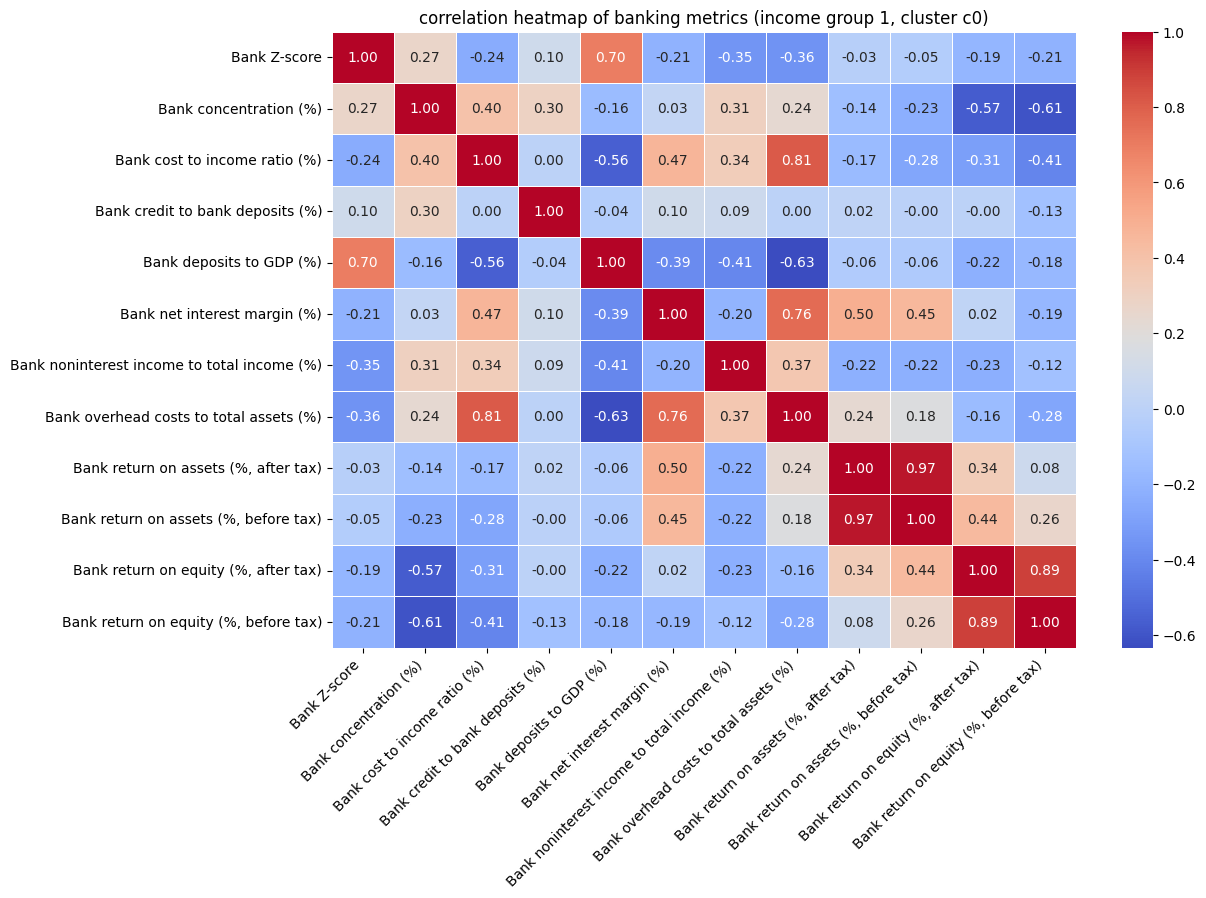

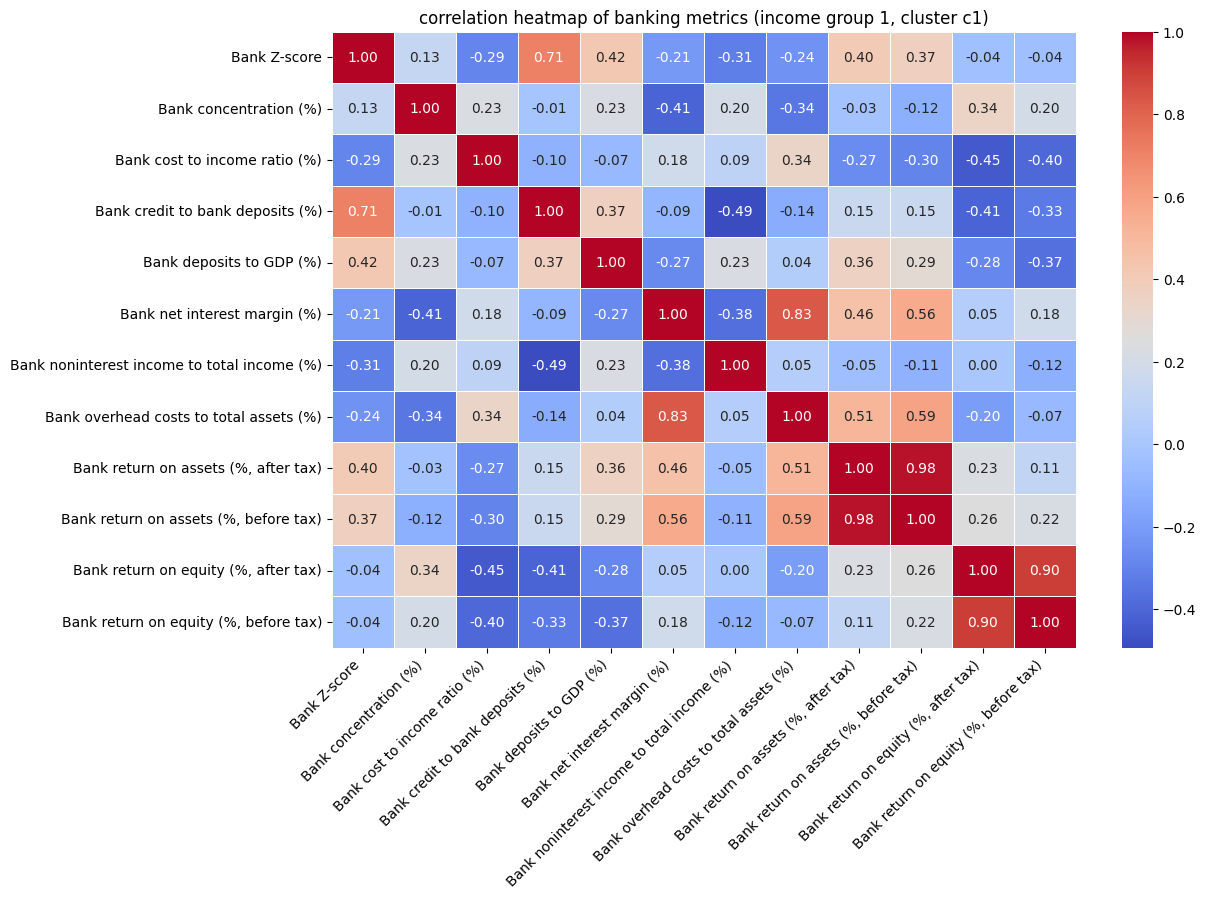

In [27]:

df_country=df_country.copy()  
df_country["Banking_Cluster"]=df_country["Banking_Cluster"].astype("category")  

income_groups=[3,2,1] 

#correlation heatmap per income group and cluster  
for income_group in income_groups:  
    for cluster in ["c0","c1"]:  
        df_subset=df_country[(df_country["Income_Group"]==income_group)&(df_country["Banking_Cluster"]==cluster)]  
        if len(df_subset)>1:  
            correlation_matrix=df_subset[banking_metrics].corr(numeric_only=True)  
            
            plt.figure(figsize=(12,8))  
            sns.heatmap(correlation_matrix,annot=True,fmt=".2f",cmap="coolwarm",linewidths=0.5)  
            plt.title(f"correlation heatmap of banking metrics (income group {income_group}, cluster {cluster})")  
            plt.xticks(rotation=45,ha="right")  
            plt.yticks(rotation=0)  
            plt.show()  

# Banking Cluster Analysis | Market Competition vs. Profitability

This section examines banking clusters in middle-income (Group 2) and high-income (Group 3) economies, focusing on market concentration, profitability, lending behavior, and efficiency.

---

## Middle-Income Countries (Income Group 2)
| Metric | Cluster 0 (c0) | Cluster 1 (c1) |
|--------|--------------|--------------|
| Bank Stability (Z-score) | 16.47 | 15.32 |
| Market Concentration (%) | 71.32 | 58.91 |
| Lending Approach (Credit-to-Deposits Ratio) | 98.43 | 103.45 |
| Profitability (ROA / ROE, after tax) | 2.43% / 18.92% | 0.99% / 10.36% |
| Efficiency (Cost-to-Income / Overhead Costs) | 58.09% / 5.92% | 54.79% / 3.66% |

---

## High-Income Countries (Income Group 3)
| Metric | Cluster 0 (c0) | Cluster 1 (c1) |
|--------|--------------|--------------|
| Bank Stability (Z-score) | 18.63 | 15.78 |
| Market Concentration (%) | 76.54 | 68.67 |
| Lending Approach (Credit-to-Deposits Ratio) | 102.05 | 113.52 |
| Profitability (ROA / ROE, after tax) | 1.20% / 12.09% | 0.28% / 4.09% |
| Efficiency (Cost-to-Income / Overhead Costs) | 48.94% / 1.83% | 63.12% / 1.44% |

---

## Key Insights
- Cluster 0 consists of banking systems with higher market concentration, stronger profitability, and lower operational costs.  
  - These systems are dominated by fewer banks that maintain efficiency and profitability through higher interest margins and cost control.  
  - They tend to be more stable but less flexible in adjusting to economic changes.  

- Cluster 1 consists of more competitive, fragmented banking systems with a focus on cost efficiency and lending volume.  
  - These systems have more decentralized banking markets, with institutions competing aggressively, leading to thinner margins and lower profitability.  
  - Higher credit-to-deposit ratios indicate a greater reliance on external funding, making these systems more adaptable but also more sensitive to financial cycles.  

- The same patterns hold across both middle-income and high-income economies:  
  - Cluster 0 banking structures rely on concentration and efficiency.  
  - Cluster 1 banking structures emphasize competition and lending activity.  

---

## Interpretation
Banking clusters reflect the degree of competition and concentration within financial systems rather than a simple stability vs. risk distinction.

- Cluster 0 nations have concentrated banking sectors where fewer institutions control most financial assets. These systems generate stable profits and operate at lower costs.  
- Cluster 1 nations have competitive and fragmented banking sectors with many institutions competing for market share. These systems prioritize lending and cost efficiency but operate with lower margins and greater exposure to external funding.


In [28]:
#group countries by income group and banking cluster  
clustered_countries=df.groupby(["Income_Group","Banking_Cluster"])["Country Name"].unique().to_dict()  

#convert to readable format  
clustered_countries_dict={f"income group {income_group} - cluster {banking_cluster}":list(countries) for (income_group,banking_cluster),countries in clustered_countries.items()}  

#print grouped countries  
for group,countries in clustered_countries_dict.items():  
    print(f"\n### {group} countries:\n")  
    print(", ".join(countries))  




### income group 1 - cluster c0 countries:

Bangladesh, Benin, Bolivia, Burkina Faso, Cambodia, Cameroon, Congo, Dem. Rep., Cote d'Ivoire, El Salvador, Guatemala, Honduras, India, Indonesia, Jordan, Kyrgyz Republic, Mali, Mauritania, Moldova, Morocco, Nepal, Niger, Pakistan, Philippines, Senegal, Uzbekistan

### income group 1 - cluster c1 countries:

Angola, Burundi, Ghana, Haiti, Jamaica, Kenya, Lesotho, Madagascar, Mozambique, Namibia, Nicaragua, Rwanda, Sierra Leone, Tanzania, Uganda, Zambia

### income group 2 - cluster c0 countries:

Argentina, Belarus, Botswana, Dominican Republic, Georgia, Guyana, Paraguay, Peru, South Africa

### income group 2 - cluster c1 countries:

Albania, Algeria, Armenia, Azerbaijan, Bosnia and Herzegovina, Brazil, Bulgaria, Chile, China, Costa Rica, Croatia, Ecuador, Egypt, Arab Rep., Kazakhstan, Latvia, Lebanon, Libya, Malaysia, Mauritius, Mexico, Mongolia, Montenegro, North Macedonia, Panama, Romania, Russian Federation, Serbia, Thailand, Tunisia, U

# Banking Clusters in Middle-Income and High-Income Economies

This section analyzes Cluster 0 (concentrated banking systems) and Cluster 1 (competitive banking systems) in both middle-income (Group 2) and high-income (Group 3) economies.

---

## Middle-Income Countries (Group 2)  

### Cluster 0 (c0) - Concentrated banking systems  
Countries: Argentina, Belarus, Botswana, Dominican Republic, Georgia, Guyana, Paraguay, Peru, South Africa  

- A few large banks control most financial activity.  
- Higher profitability and efficiency due to economies of scale.  
- Lower competition, leading to more stable but less dynamic credit markets.  
- Example: South Africa’s banking system is dominated by a few major banks, limiting competition but maintaining profitability.  

### Cluster 1 (c1) - Competitive banking systems  
Countries: Albania, Algeria, Brazil, Chile, China, Egypt, Kazakhstan, Malaysia, Mexico, Thailand, Ukraine  

- More fragmented banking markets with many competing institutions.  
- Lower profitability due to competition driving down interest margins.  
- Greater reliance on external funding and deposit growth.  
- Example: Brazil has a mix of state-owned, private, and fintech banks competing aggressively for market share.  

---

## High-Income Countries (Group 3)  

### Cluster 0 (c0) - Concentrated banking systems  
Countries: Canada, Saudi Arabia, Singapore, UAE, Australia, United States, Hong Kong  

- A few major banks dominate financial services, leading to efficiency and profitability.  
- Lower competition with strong market control by large institutions.  
- Limited reliance on external funding.  
- Example: Canada’s "Big Five" banks control most financial services, ensuring stability but limiting competition.  

### Cluster 1 (c1) - Competitive banking systems  
Countries: Germany, France, Japan, Switzerland, Netherlands, Italy  

- More decentralized banking structures with many institutions competing for market share




# What About Group 1 (Developing Countries)?

The reason group 1 hasn't been discussed yet is that its clusters represent different dynamics than those in groups 2 and 3.

In low-income economies, banking clusters reflect financial development and system strength rather than market competition.

---

## Cluster 0 (c0) - More Developed, Stable Banking Systems  
- Higher financial stability (Z-score: +0.27).  
- More effective at mobilizing deposits (Deposits to GDP: +0.32).  
- Lower costs and higher profitability (lower overhead, higher ROA/ROE).  
- Banking services are more widely available.  
- Example: Countries where banking systems are better integrated into the economy.  

Represents stronger, more efficient financial systems.  

---

## Cluster 1 (c1) - Less Developed, Fragile Banking Systems  
- Higher costs and inefficiency (higher net interest margins: +0.77, overhead costs: +0.61).  
- Weaker financial institutions (lower ROA/ROE).  
- Struggles to mobilize savings (Deposits to GDP: -0.32).  
- Limited access to banking services, with institutions taking more risks.  
- Example: Countries where banking remains underdeveloped and costly.  

Represents weaker, riskier financial systems with less accessibility.  

---

## Summary  
- Cluster 0 consists of more stable, financially developed banking structures.  
- Cluster 1 consists of weaker, riskier, and less efficient banking systems.  
- Unlike in middle- and high-income countries, clustering here is about financial maturity, not market competition.


In [29]:
# reimplementing the aggregation process with debugging steps
def compute_volatility(df,income_group):  
    df_filtered=df[df["Income_Group"]==income_group].copy()  
    for feature in macro_features:  
        vol_col=f"{feature}_Volatility"  
        df_filtered[vol_col]=df_filtered.groupby("Country Name")[feature].rolling(window=3,min_periods=2).std().droplevel(0)  

        Q1,Q3=df_filtered[vol_col].quantile([0.25,0.75])  
        IQR=Q3-Q1  
        df_filtered=df_filtered[df_filtered[vol_col].between(Q1-1.5*IQR,Q3+1.5*IQR)]  
    return df_filtered  

macro_features=[
    "GDP growth (annual %)",
    "Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)",
    "Gross capital formation (% of GDP)",
    "Inflation, GDP deflator (annual %)"
]


income_groups = [3, 2, 1]

group_avgs = []

macro_features=[
    "GDP growth (annual %)",
    "Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)",
    "Gross capital formation (% of GDP)",
    "Inflation, GDP deflator (annual %)"
]

income_groups=[3,2,1]
group_avgs=[]

for group in income_groups:
    dft=compute_volatility(df,group)
    print(f"Income Group {group}: {dft.shape}")
    if dft.empty:
        print(f"Skipping Income Group {group} because it's empty.")
        continue
    numeric_cols=dft.select_dtypes(include=['number']).columns
    dfg=(
        dft.groupby(["Year","Banking_Cluster"])[numeric_cols]
        .mean(numeric_only=True)
        .unstack(level=1)
    )
    group_avgs.append(dfg)

print(f"Total DataFrames created: {len(group_avgs)}")



Income Group 3: (451, 27)
Income Group 2: (456, 27)
Income Group 1: (460, 27)
Total DataFrames created: 3


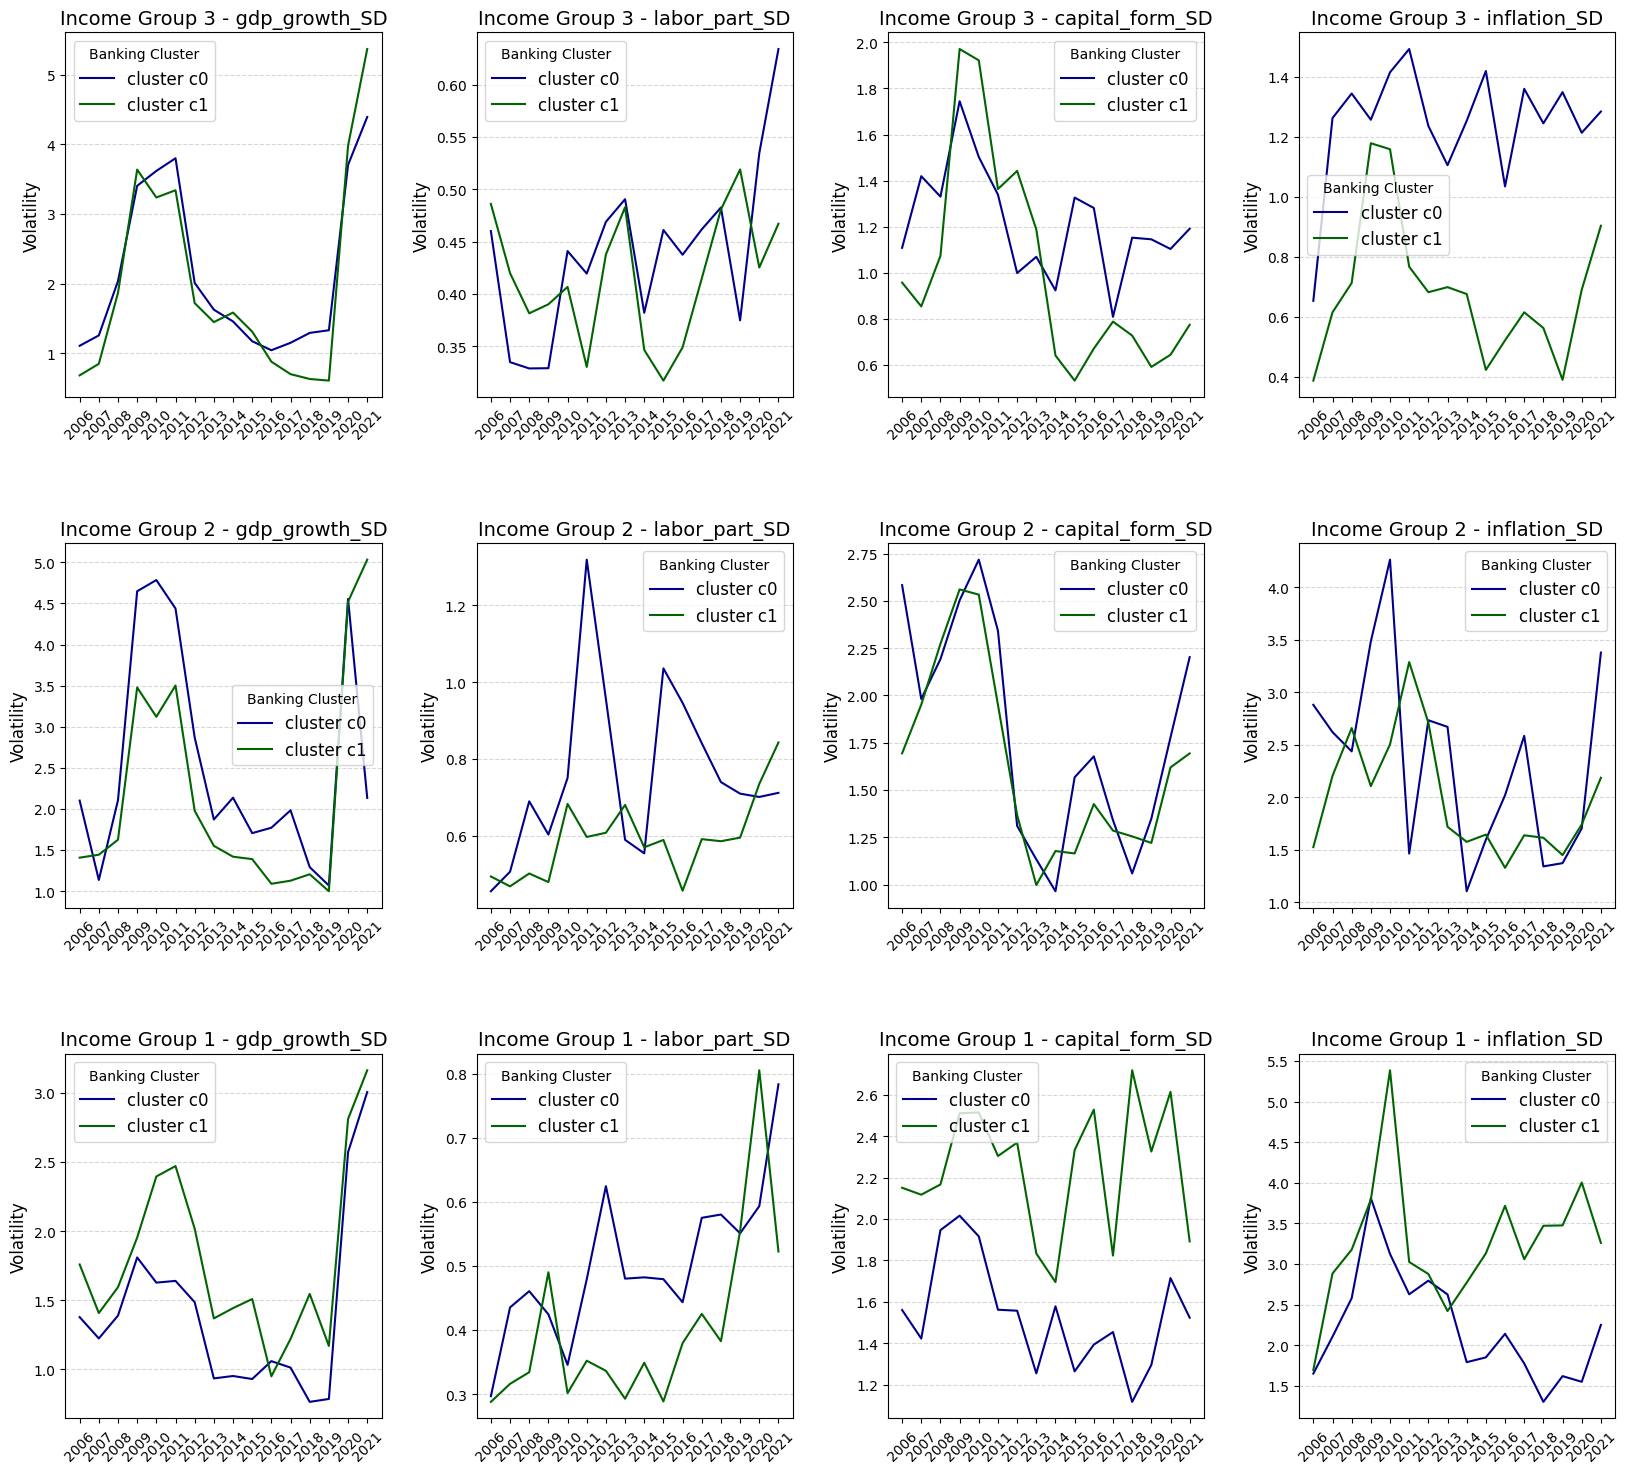

In [30]:
volatility_rename={
    "GDP growth (annual %)_Volatility":"gdp_growth_SD",
    "Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)_Volatility":"labor_part_SD",
    "Gross capital formation (% of GDP)_Volatility":"capital_form_SD",
    "Inflation, GDP deflator (annual %)_Volatility":"inflation_SD"
}

volatility_features=list(volatility_rename.values())

group_avgs=[dft_avg.rename(columns=volatility_rename,level=0) for dft_avg in group_avgs]

fig,axes=plt.subplots(len(income_groups),len(volatility_features),figsize=(20,18),sharex=False)

colours={"c1":'darkgreen',"c0":'darkblue'}

for i,(group,dft_avg) in enumerate(zip(income_groups,group_avgs)):
    for j,feature in enumerate(volatility_features):
        ax=axes[i,j]
        for cluster in ["c0","c1"]:
            if (feature,cluster) in dft_avg:
                ax.plot(
                    dft_avg.index,
                    dft_avg[(feature,cluster)],
                    label=f"cluster {cluster}",
                    color=colours[cluster]
                )
        ax.set_title(f"Income Group {group} - {feature}",fontsize=14)
        ax.set_ylabel("Volatility",fontsize=12)
        ax.legend(title="Banking Cluster",fontsize=12)
        ax.grid(axis="y",linestyle="--",alpha=0.5)
        ax.tick_params(axis="x",rotation=45)

plt.subplots_adjust(hspace=0.4,wspace=0.3)
plt.show()


### **Interesting Observations:**

**Group 1**: Persistently lower inflation volatility amongst the more competitive cluster, and lower investment volatiltiy during non crisis years (years that arent aren't around 2008)

**Group 2**: Persistently less volatile GDP growth, even during crisis years, and persistently less volatile labor markets in the competive cluster, slgihtly less investment volatility, smaller swings inflation volatiltiy in the more competitive markets cluster 1

**Group 3**: Instable and underdeveloped banking systems show more volatile GDP growth, more volatile investment and inflation. But suprisingly not labour markets

**All well and good but? Is anu of this statisically signfiicant?**

# **T-Tests and Visualising Mean difference between clusters**

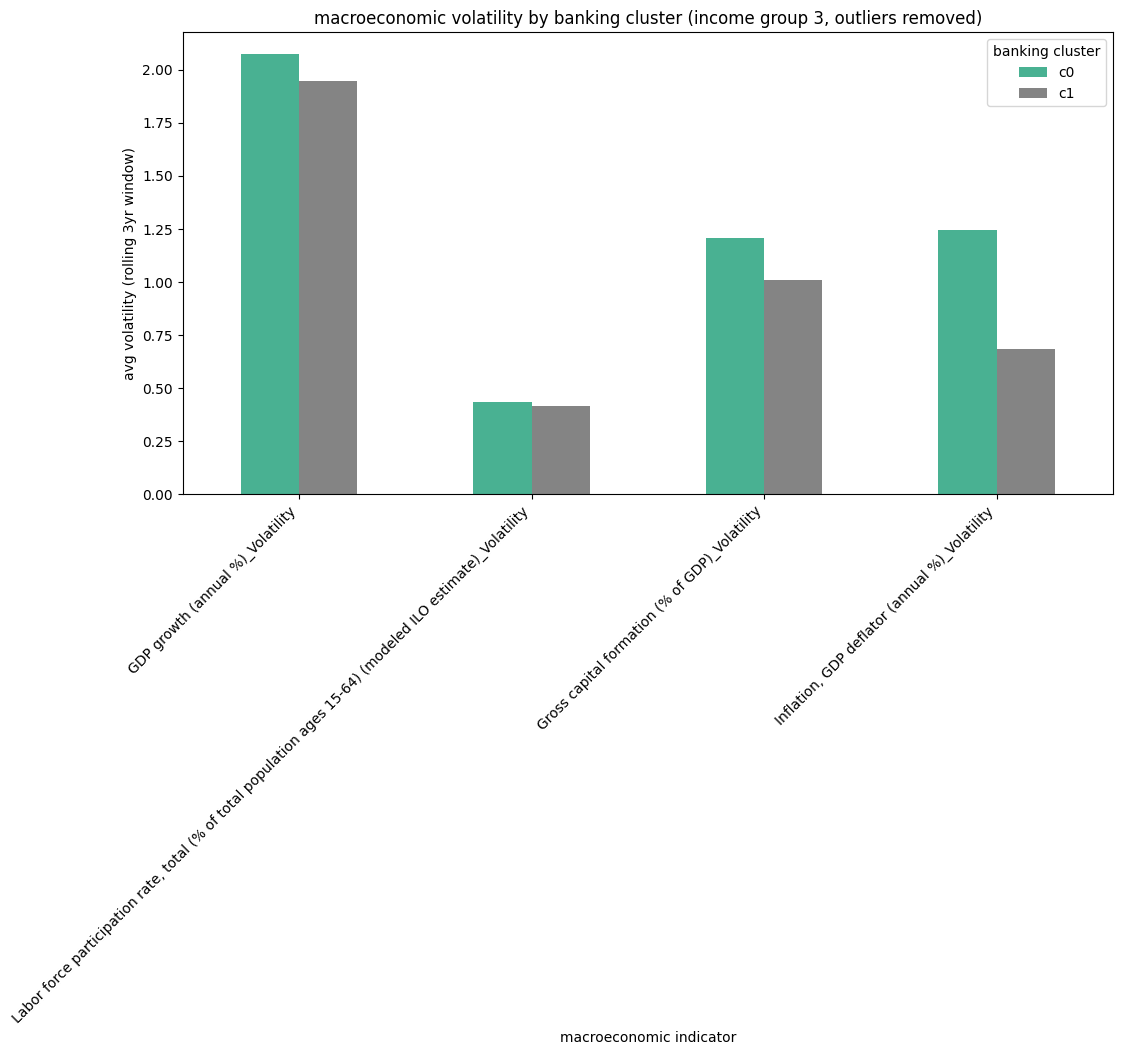

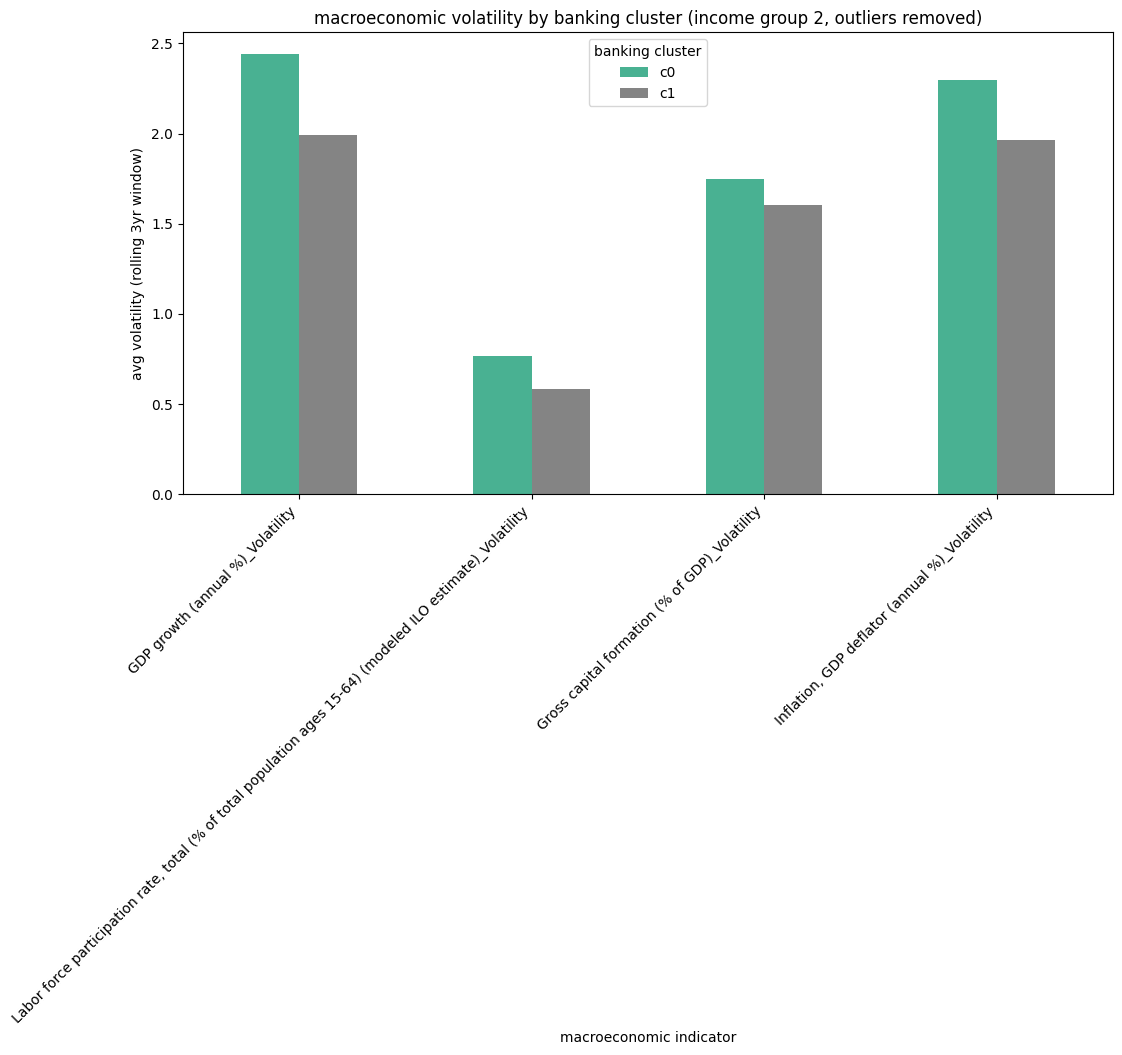

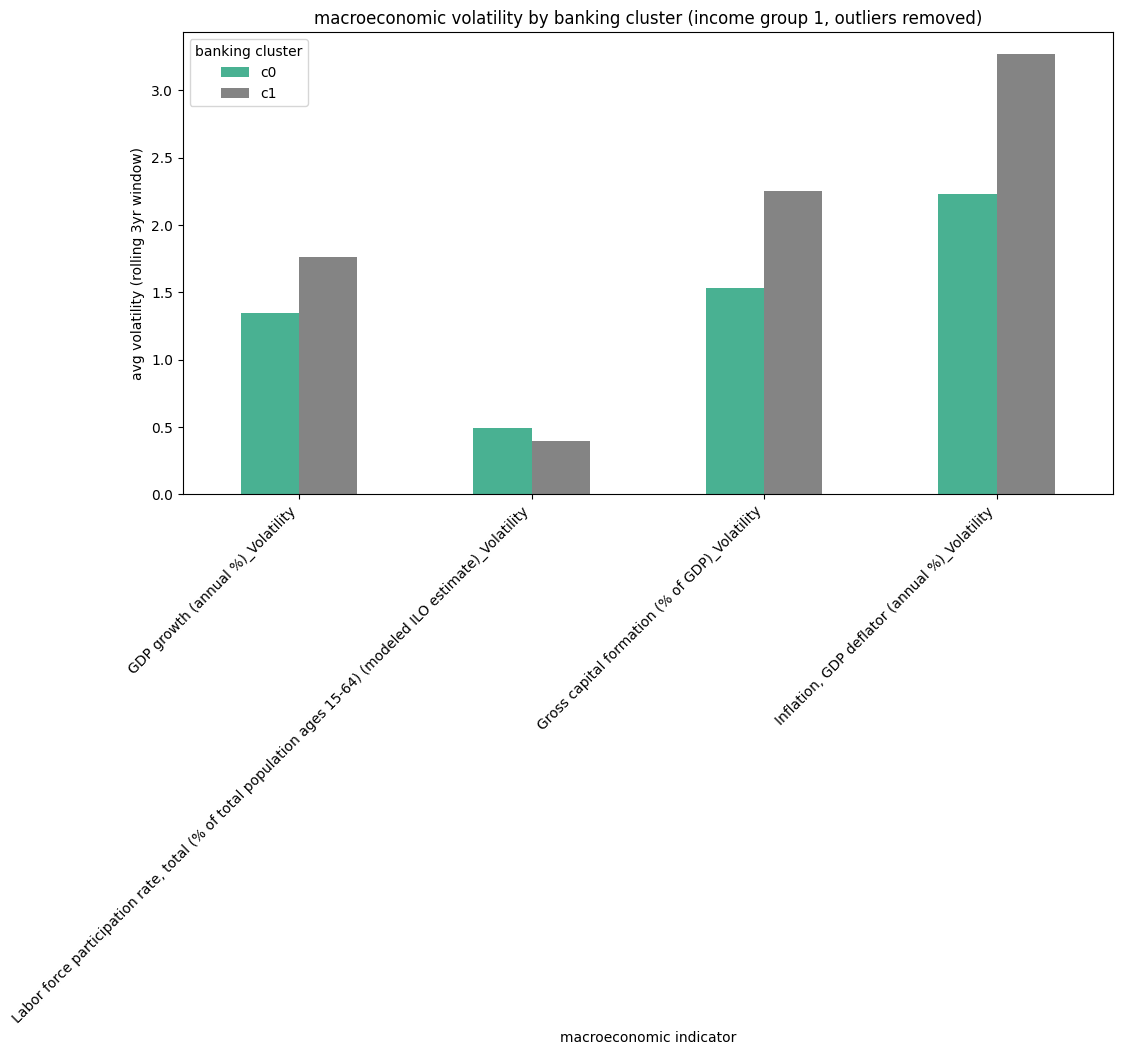


### consolidated t-test results with effect sizes (Cohen's d) ###
income group 3 | GDP growth (annual %): t-stat=0.802, p-value=0.423, cohen's d=0.076
income group 3 | Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate): t-stat=0.804, p-value=0.422, cohen's d=0.076
income group 3 | Gross capital formation (% of GDP): t-stat=2.546, p-value=0.011, cohen's d=0.240
income group 3 | Inflation, GDP deflator (annual %): t-stat=7.820, p-value=0.000, cohen's d=0.733
income group 2 | GDP growth (annual %): t-stat=1.981, p-value=0.050, cohen's d=0.250
income group 2 | Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate): t-stat=3.142, p-value=0.002, cohen's d=0.389
income group 2 | Gross capital formation (% of GDP): t-stat=1.071, p-value=0.286, cohen's d=0.129
income group 2 | Inflation, GDP deflator (annual %): t-stat=1.538, p-value=0.127, cohen's d=0.194
income group 1 | GDP growth (annual %): t-stat=-3.529

In [31]:
import pandas as pd  
import numpy as np  
from scipy.stats import ttest_ind  

income_groups = [3,2,1]

#a proxy for macroeconomic stability is the SD of the measure in question
#i remove outliers because one or two banking blunder countries in each group ruin any good visualisation i could get
def compute_volatility(df,income_group):  
    df_filtered=df[df["Income_Group"]==income_group].copy()  
    for feature in macro_features:  
        vol_col=f"{feature}_Volatility"  
        df_filtered[vol_col]=df_filtered.groupby("Country Name")[feature].rolling(window=3,min_periods=2).std().droplevel(0)  

        Q1,Q3=df_filtered[vol_col].quantile([0.25,0.75])  
        IQR=Q3-Q1  
        df_filtered=df_filtered[df_filtered[vol_col].between(Q1-1.5*IQR,Q3+1.5*IQR)]  
    return df_filtered  

def cohens_d(x, y):
    """calculates effect size to check if statistical significance is meaningful"""
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2)

t_test_results=[]  

#plots mean differences between clusters and does T-tests + Cohen's d
for group in income_groups:  
    df_volatility=compute_volatility(df,group)  
    for feature in macro_features:  
        vol_col=f"{feature}_Volatility"  
        c0_values=df_volatility[df_volatility["Banking_Cluster"]=="c0"][vol_col].dropna()  
        c1_values=df_volatility[df_volatility["Banking_Cluster"]=="c1"][vol_col].dropna()  

        t_stat, p_value = ttest_ind(c0_values, c1_values, equal_var=False, nan_policy="omit")  
        d_value = cohens_d(c0_values, c1_values)  
        t_test_results.append((group, feature, t_stat, p_value, d_value))  

    volatility_df=df_volatility.groupby("Banking_Cluster")[[f"{f}_Volatility" for f in macro_features]].mean()  
    volatility_df.T.plot(kind="bar",figsize=(12,6),colormap="Dark2",alpha=0.8)  
    plt.xlabel("macroeconomic indicator")  
    plt.ylabel("avg volatility (rolling 3yr window)")  
    plt.title(f"macroeconomic volatility by banking cluster (income group {group}, outliers removed)")  
    plt.xticks(rotation=45,ha="right")  
    plt.legend(title="banking cluster")  
    plt.show()  

print("\n### consolidated t-test results with effect sizes (Cohen's d) ###")  
for group, feature, t_stat, p_value, d_value in t_test_results:  
    print(f"income group {group} | {feature}: t-stat={t_stat:.3f}, p-value={p_value:.3f}, cohen's d={d_value:.3f}")  


# **Consolidated T-Test Results and Cohen's d Analysis**  

### **Significant Variables (p-value < 0.05)**  

### **Income Group 3 (High-Income Economies)**
- **Gross capital formation (% of GDP)**  
  - t-stat = 2.546, p-value = 0.011, Cohen’s d = 0.240  
  - **Interpretation:** Small effect size. Banking structure has an impact on investment volatilit although it is small.  

- **Inflation, GDP deflator (annual %)**  
  - t-stat = 7.820, p-value = 0.000, Cohen’s d = 0.733  
  - **Interpretation:** Large effect size. Competitive banking systems (Cluster 1) are associated with significantly lower inflation volatility.  

---

### **Income Group 2 (Middle-Income Economies)**
- **GDP growth (annual %)**  
  - t-stat = 1.981, p-value = 0.050, Cohen’s d = 0.250  
  - **Interpretation:** Small to moderate effect size. Banking structure plays some role in stabilizing GDP growth, but it is not the dominant factor.  

- **Labor force participation rate, total (% of population ages 15-64)**  
  - t-stat = 3.142, p-value = 0.002, Cohen’s d = 0.389  
  - **Interpretation:** Moderate effect size. Banking structure influences labor market stability more in middle-income economies.  

---

### **Income Group 1 (Low-Income Economies)**
- **GDP growth (annual %)**  
  - t-stat = -3.529, p-value = 0.000, Cohen’s d = -0.351  
  - **Interpretation:** Moderate effect size. Underdeveloped banking systems (Cluster 1) correlate with more volatile GDP growth.  

- **Labor force participation rate, total (% of population ages 15-64)**  
  - t-stat = 2.541, p-value = 0.011, Cohen’s d = 0.242  
  - **Interpretation:** Small to moderate effect. Strangely underdeveloped banking systems have slightly less volatile labor markets.

- **Gross capital formation (% of GDP)**  
  - t-stat = -5.872, p-value = 0.000, Cohen’s d = -0.577  
  - **Interpretation:** Large effect size. Under-developed banking systems (Cluster 1) are linked to significantly more volatile investment cycles.  

- **Inflation, GDP deflator (annual %)**  
  - t-stat = -5.352, p-value = 0.000, Cohen’s d = -0.524  
  - **Interpretation:** Large effect size. Underdeveloped banking systems (Cluster 1) lead to more inflation volatility in low-income economies.  

---



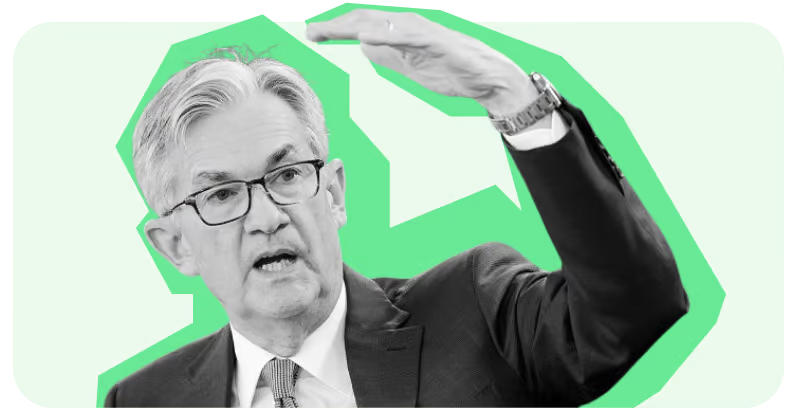

*img of J Pow to breakup the text, i thought it fit with the colour scheme so far and he's pretty related to macro*

# **Macroeconomic Volatility and Banking Structure in High-Income Economies (Group 3)**

This analysis examines how banking structure affects macroeconomic stability in high-income economies. The results indicate that more competitive and fragmented banking markets (Cluster 1) are associated with lower volatility in investment and inflation.  

---

## Key Findings  
- GDP growth volatility is similar across clusters, suggesting that banking structure has little influence on economic growth stability in developed economies.  
- Labour force participation volatility is low and nearly identical across clusters, reinforcing that banking structure has minimal direct impact on labour markets.  
- Gross capital formation volatility is moderately lower in Cluster 1, suggesting that more competitive banking markets contribute to more stable investment cycles.  
- Inflation volatility is significantly lower in Cluster 1, implying that competitive banking systems help smooth price fluctuations, likely through more flexible credit markets and better monetary transmission.  

The latter two findings are statistically significant based on the T-tests.  

---

## Interpretation  
In high-income economies, financial systems are well-developed, and capital markets play a major role in economic activity. As a result, the main effect of banking structure is on investment stability and inflation management rather than direct economic growth or employment stability.  

- Cluster 0 (concentrated banking markets) provides financial stability but may amplify price and investment fluctuations due to lower competition and slower credit adjustments.  
- Cluster 1 (competitive banking markets) appears to distribute financial risk more effectively, reducing macroeconomic volatility.  

---
## **Possible Explanations for Lower Inflation and Investment Volatility in Cluster 1** | potential ideas for future study

### 1. More Flexible Credit Adjustment  
- In competitive banking markets, firms and consumers have more borrowing options, leading to quicker adjustments in response to economic shifts.  
- This reduces credit supply shocks that could otherwise increase economic volatility.  

### 2. Decentralised Risk Absorption  
- In concentrated banking markets (Cluster 0), a few dominant banks control most lending. If they tighten credit conditions, the entire economy can experience a sharp contraction.  
- In competitive markets, risk is spread across many institutions, reducing the likelihood of a system-wide liquidity crunch.  

### 3. More Efficient Monetary Transmission  
- Competitive banks adjust lending rates more dynamically in response to interest rate changes, ensuring monetary policy has a smoother effect on inflation and investment.  
- In contrast, large concentrated banks may delay or resist rate adjustments, leading to lagged or amplified economic responses.  

### 4. Reduced Financial Sector Shocks  
- Large, dominant banks can sometimes create systemic risks, especially when overleveraged or too interconnected.  
- A fragmented banking system ensures that failures in one institution have less impact, contributing to overall financial stability.  


In [72]:
# this code block is more for visual seperation of this text wall 
# so is the image below (bank of thailand)

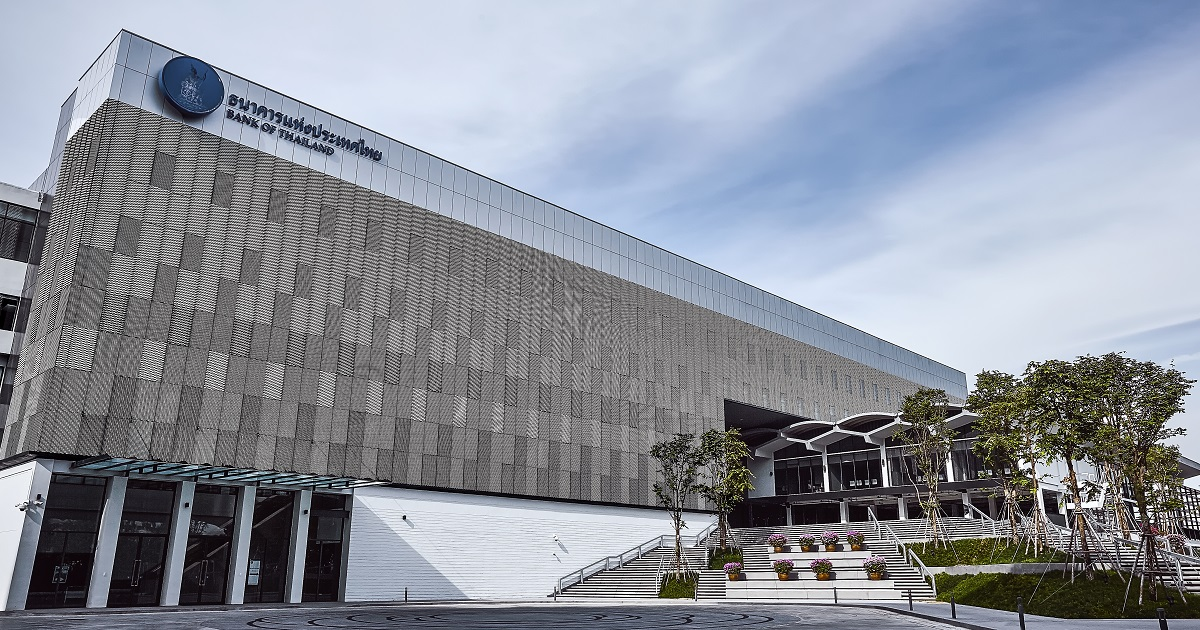

# **Hypothesis for Further Investigation | Why Does Banking's Impact Shift as Economies Develop?**  

As economies develop, the role of banking systems changes, shifting from a driver of economic growth and employment stability in middle-income countries to a stabiliser of investment and inflation in high-income nations. This is reflected in the differences in which macroeconomic factors banking market structure has statistical significance.  

---

## Emerging Economies (Group 2)  
- Banks play a central role in economic expansion, making GDP growth and labour market stability highly sensitive to banking structures.  
- **Significant T-Tests:**  
  - GDP growth volatility: t-stat = 1.981, p-value = 0.050  
  - Labour force participation volatility: t-stat = 3.142, p-value = 0.002  
- **Implication:**  
  - Banking structure influences credit access, employment cycles, and economic volatility in these transitioning economies.  
  - Competitive banking systems may support economic stability by improving credit availability, while concentrated systems may restrict access, increasing economic volatility.  
  - Concentrated systems seeking higher margins may contract lending excessively during downturns, exacerbating economic contractions, and fail to expand credit during booms.  

---

## Highly Developed Economies (Group 3)  
- Banks play a reduced role in driving GDP and employment stability, as mature economies rely more on capital markets for financing.  
- Banking systems instead shape investment and inflation cycles through credit conditions and monetary policy transmission.  
- **Significant T-Tests:**  
  - Gross capital formation volatility: t-stat = 2.546, p-value = 0.011  
  - Inflation volatility: t-stat = 7.820, p-value = 0.000  
- **Implication:**  
  - More competitive banking systems help stabilise investment cycles and smooth inflation.  
  - Concentrated banking markets may amplify monetary distortions, leading to greater price volatility.  

---
## Key Insight  
- In middle-income economies, banking systems contribute to economic expansion and employment stability.  
- In high-income economies, banks influence investment and inflation cycles rather than directly affecting GDP growth.  
- Stable banking structures do not always ensure smooth macroeconomic conditions—rather, they may have developed in response to past volatility rather than as a tool to prevent it.  


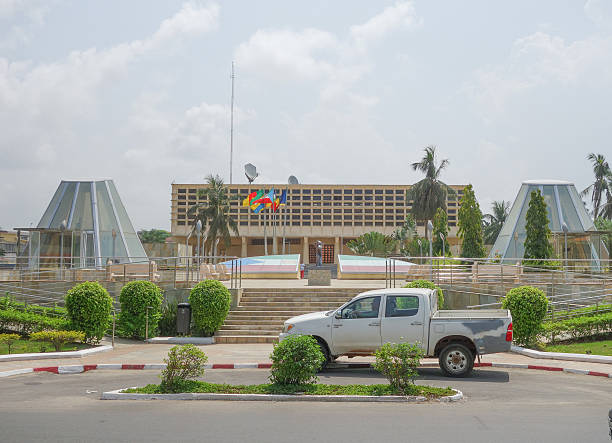     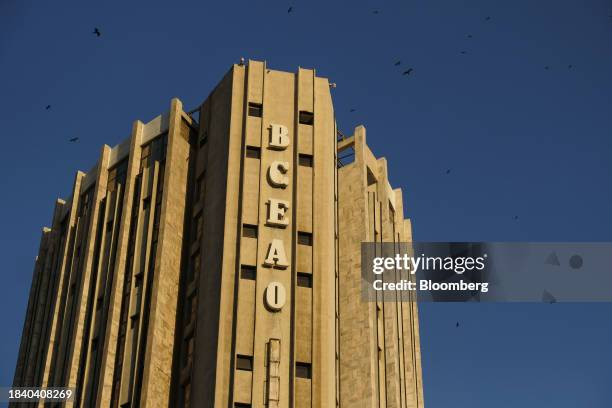  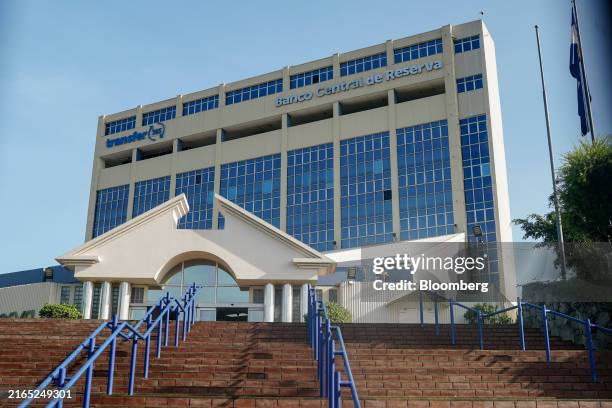
*images of various central banks from income group 1 to break up this text wall* 

# **Banking Structures and Economic Volatility in Developing Economies**  

In low-income economies (Group 1), banking structures significantly impact all macro-volatility indicators, unlike in wealthier nations where the effect is more selective. This suggests that underdeveloped banking systems amplify economic fragility.  

---

### Key Characteristics of Banking Clusters in Low-Income Economies  
- **Cluster 1 banks are not aggressive lenders but inefficient and restrictive.**  
  - More concentrated (73.83% vs. 60.91%), likely due to limited banking availability rather than monopolisation.  
  - More conservative lending (67.54% credit-to-deposit ratio vs. 84.06%), restricting financial access.  
  - Higher cost-to-income and overhead costs, reducing banking efficiency.  
- This contrasts with Cluster 1 in higher-income economies, where banks were more efficient and engaged in leveraged lending.  

---

### Why Does Banking Structure Matter More in Developing Economies?  

1. **Banking Risk Reflects Structural Weakness, Not Over-Lending**  
   - Unlike developed markets, where financial instability stems from excessive leverage, low-income economies struggle with fragile and inefficient banking systems.  

2. **Limited Credit Access Increases Economic Volatility**  
   - Fewer banks mean less financial inclusion, forcing reliance on informal lending and external capital flows, which can be highly volatile.  

3. **Restrictive Lending Exacerbates Boom-Bust Cycles**  
   - Low credit-to-deposit ratios prevent credit expansion during booms and accelerate contractions in downturns, increasing macroeconomic instability.  

4. **Inefficiency Reduces Financial Shock Absorption**  
   - High operational costs and poor cost efficiency weaken the financial system's ability to absorb external shocks.  

---

### Key Insight  
- Financial instability in low-income economies is driven by inefficiency, restricted credit access, and underdeveloped financial institutions—not excessive risk-taking.  
- Expanding banking access and improving efficiency may enhance stability more effectively than stricter financial regulation.  

---


# **Conclusion**  

#### **Differences in banking systems have tangible effects on macroeconomic stability, but! their impact varies significantly depending on a country’s level of economic development.**
---

#### **Highly Developed Nations**
In high-income (Group 3) economies, the distinction between clusters represents **variations in market competition**. More competitive banking markets in highly developed economies are generally linked to **lower investment and inflation volatility**, likely due to more flexible credit markets and more effective monetary transmission.  

#### **Emerging Economies**
In emerging economies (Group 2), the distinction still reflects market competition, but the effect of banking structures shifts towards **stabilising GDP growth fluctuations and labour market volatility**. In these economies, financial institutions play a more direct role in maintaining macroeconomic stability by influencing credit availability and employment cycles.  

#### **Developing Nations** 

In low-income economies (Group 1), the clustering does not reflect competition but rather the **degree of financial system development**. Here, **Cluster 1 represents underdeveloped and unstable banking systems** rather than competitive ones. These economies suffer from weaker banking infrastructure, restricted credit access, and inefficiencies, which amplify volatility across all macroeconomic indicators. **Financial instability in poorer economies is not driven by excessive risk-taking but by structural weaknesses that limit the effectiveness of the banking sector**.  

---

#### **Policy Insights**  

The findings indicate that different economic groups require **tailored banking policies** to enhance financial stability and economic resilience.  

- **High-Income Economies (Group 3):** Policies should encourage **healthy competition in banking markets** to sustain efficient monetary transmission and stabilise investment and inflation. Ensuring that large banks do not stifle competition while maintaining financial stability is key.  

- **Emerging Economies (Group 2):** Given the role of banking in **stabilising GDP growth and labour markets**, policies should focus on **ensuring accessible and countercyclical credit provision**. Strengthening regulatory frameworks to prevent excessive credit contraction during downturns and encouraging financial sector diversification can help reduce volatility.  

- **Low-Income Economies (Group 1):** The priority should be **developing basic financial infrastructure, increasing banking penetration, and improving efficiency**. Expanding financial inclusion, strengthening deposit security, and modernising banking systems will be more effective than imposing stricter regulations designed for developed markets.  

A **one-size-fits-all** approach to banking policy is unlikely to work across different economic contexts. Instead, policies should align with the **specific role banking systems play in each income group**, ensuring stability while supporting broader economic development.  

